<a href="https://colab.research.google.com/github/nouhRifai/covid-europe/blob/main/Covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Solution proposée**
  - Input : date (year-week), pop, country, tests, positivity, icu admission, country measures
  - Output : new cases on a specific age marge
  - Work Process : 
      - Data Preprocessing
      - Data Visualization (added when implemented in streamlit)
      - Supervised-learning (Application of multiple algorithms) + DL ev.
      - Cross-validation
      - Verification of bias and variance and improving the model eventually
      - Indudstrializing in streamlit and heroku


In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
COUNTRY_MEASURES_DATASET = 'https://www.ecdc.europa.eu/sites/default/files/documents/response_graphs_data_2021-12-09.csv'
DAILY_CASES_DATASET = 'https://opendata.ecdc.europa.eu/covid19/nationalcasedeath_eueea_daily_ei/csv'
AGE_SPECIFIC_CASES_DATASET = 'https://opendata.ecdc.europa.eu/covid19/agecasesnational/csv/data.csv'
TESTING_DATASET = 'https://opendata.ecdc.europa.eu/covid19/testing/csv/data.csv'
HOSPITAL_ICU_ADMISSION = 'https://opendata.ecdc.europa.eu/covid19/hospitalicuadmissionrates/csv/data.csv'

# Data Preprocessing

## **daily_cases Preprocessing**

In [5]:
daily_cases = pd.read_csv(DAILY_CASES_DATASET)

In [6]:
daily_cases.head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp
0,22/12/2021,22,12,2021,1913,40,Austria,AT,AUT,8901064,Europe
1,21/12/2021,21,12,2021,1863,20,Austria,AT,AUT,8901064,Europe
2,20/12/2021,20,12,2021,2131,13,Austria,AT,AUT,8901064,Europe
3,19/12/2021,19,12,2021,2378,17,Austria,AT,AUT,8901064,Europe
4,18/12/2021,18,12,2021,2577,51,Austria,AT,AUT,8901064,Europe


In [7]:
daily_cases.isnull().sum()

dateRep                    0
day                        0
month                      0
year                       0
cases                      0
deaths                     0
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2020                0
continentExp               0
dtype: int64

In [8]:
daily_cases.describe()

,day,month,year,cases,deaths,popData2020
count,8910.000000,8910.000000,8910.0,8.910000e+03,8910.000000,8.910000e+03
mean,15.465320,7.362514,2021.0,5.865159e+03,99.634568,1.510301e+07
std,8.737133,2.807657,0.0,7.247804e+04,1872.570180,2.121567e+07
min,1.000000,2.000000,2021.0,-2.001000e+03,-3.000000,3.874700e+04
25%,8.000000,5.000000,2021.0,1.720000e+02,0.000000,2.095861e+06
50%,15.000000,7.000000,2021.0,8.200000e+02,6.000000,6.387122e+06
75%,23.000000,10.000000,2021.0,3.114000e+03,34.000000,1.152244e+07
max,31.000000,12.000000,2021.0,3.645305e+06,97699.000000,8.316671e+07


After reviewing the data and in order to prepare it, we came up with the following actions :

- creating a year_week column
- handling strange values
- grouping data


### Creating a year_week column

In [9]:
#Steps to follow in order to create a new column 
#check dateRep type and change it to pd.datetime
#add a column year-week with 'apply' method df['year_week'] = df.apply(f) in:row | return val
def f(row):
  return
#groupby year-week/country agg(['sum','max']) ['cases','deaths','popData']

In [10]:
#converting dateRep column type to datetime 
daily_cases['dateRep'] = pd.to_datetime(daily_cases['dateRep'], format='%d/%m/%Y') 

In [11]:
#function to provide the year week
def set_year_week(x): 
  my_zero = ''
  if x['dateRep'].week <10:
    my_zero = '0'
  return str(x['dateRep'].year) + '-W' + my_zero + str(x['dateRep'].week)

In [12]:
#apply the function on the dataset and creating year_week column
daily_cases['year_week'] = daily_cases.apply(set_year_week , axis=1)

In [13]:
daily_cases.sort_values(['year_week','countryterritoryCode']).head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
8612,2021-02-28,28,2,2021,3109689,69142,Spain,ES,ESP,47332614,Europe,2021-W08
290,2021-03-07,7,3,2021,2846,18,Austria,AT,AUT,8901064,Europe,2021-W09
291,2021-03-06,6,3,2021,2319,16,Austria,AT,AUT,8901064,Europe,2021-W09
292,2021-03-05,5,3,2021,2691,21,Austria,AT,AUT,8901064,Europe,2021-W09
293,2021-03-04,4,3,2021,2497,17,Austria,AT,AUT,8901064,Europe,2021-W09


### Handling strange values

#### Handling negative values

In [14]:
#apply the value Nan to all the negative value of cases
daily_cases.loc[daily_cases['cases'] <0, 'cases'] = daily_cases[daily_cases['cases']< 0]['cases'].apply(lambda x : np.NaN)

In [15]:
daily_cases[daily_cases['cases'].isna()].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
189,2021-06-16,16,6,2021,NaN,2,Austria,AT,AUT,8901064,Europe,2021-W24
2054,2021-03-25,25,3,2021,NaN,1,Denmark,DK,DNK,5822763,Europe,2021-W12


In [16]:
#apply the value 0 to all the negative value of deaths
daily_cases.loc[daily_cases['deaths'] <0, 'deaths'] = daily_cases[daily_cases['deaths']< 0]['deaths'].apply(lambda x : np.NaN)

In [17]:
daily_cases[daily_cases['deaths'].isna()].head()

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
4386,2021-05-08,8,5,2021,428.0,NaN,Ireland,IE,IRL,4964440,Europe,2021-W18


In [18]:
daily_cases.isnull().sum()

dateRep                    0
day                        0
month                      0
year                       0
cases                      2
deaths                     1
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2020                0
continentExp               0
year_week                  0
dtype: int64

In [19]:
#Replace NaN values with the previous value we only have to sort it in ascending order
daily_cases = daily_cases.sort_values(['countriesAndTerritories','dateRep']).fillna(method='ffill')
daily_cases.isnull().sum()

dateRep                    0
day                        0
month                      0
year                       0
cases                      0
deaths                     0
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2020                0
continentExp               0
year_week                  0
dtype: int64

#### Handling High values

In [20]:
daily_cases[['cases','deaths']].describe()

,cases,deaths
count,8.910000e+03,8910.000000
mean,5.865494e+03,99.635578
std,7.247801e+04,1872.570127
min,0.000000e+00,0.000000
25%,1.720000e+02,0.000000
50%,8.200000e+02,6.000000
75%,3.114000e+03,34.000000
max,3.645305e+06,97699.000000


Another remarque is that the max values are so high, so we will check:

In [21]:
daily_cases.sort_values('cases',ascending=False).head(30)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
2969,2021-03-01,1,3,2021,3645305.0,86454.0,France,FR,FRA,67320216,Europe,2021-W09
8612,2021-02-28,28,2,2021,3109689.0,69142.0,Spain,ES,ESP,47332614,Europe,2021-W08
4751,2021-03-01,1,3,2021,2925265.0,97699.0,Italy,IT,ITA,59641488,Europe,2021-W09
3266,2021-03-01,1,3,2021,2447068.0,70105.0,Germany,DE,DEU,83166711,Europe,2021-W09
7127,2021-03-01,1,3,2021,1706986.0,43769.0,Poland,PL,POL,37958138,Europe,2021-W09
1781,2021-03-01,1,3,2021,1240721.0,21020.0,Czechia,CZ,CZE,10693939,Europe,2021-W09
6533,2021-03-01,1,3,2021,1087819.0,15556.0,Netherlands,NL,NLD,17407585,Europe,2021-W09
7424,2021-03-01,1,3,2021,804562.0,16317.0,Portugal,PT,PRT,10295909,Europe,2021-W09
7721,2021-03-01,1,3,2021,801994.0,20350.0,Romania,RO,ROU,19328838,Europe,2021-W09
593,2021-03-01,1,3,2021,772733.0,22383.0,Belgium,BE,BEL,11522440,Europe,2021-W09


As we know data starts from the 2021-03-01 for all countries, except Spain which have the first data in 2021-02-28.

Meaning :  the high value value indicates the cumulative cases or deaths before the the start date included.

Actions:

- Save the cumulative value in a dataframe which we are going to use in order to estimate risk (eventually)
- Delete the specific value

In [22]:
#Run once
daily_cases_cp = daily_cases

In [23]:
daily_cases = daily_cases_cp

In [24]:
daily_cases.at[8611, 'cases'] = daily_cases.iloc[8316]['cases'] + daily_cases.iloc[8317]['cases']
daily_cases.at[8611, 'deaths'] = daily_cases.iloc[8316]['deaths'] + daily_cases.iloc[8317]['deaths']
daily_cases[daily_cases['countriesAndTerritories']=='Spain'].head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
8612,2021-02-28,28,2,2021,3109689.0,69142.0,Spain,ES,ESP,47332614,Europe,2021-W08
8611,2021-03-01,1,3,2021,3125667.0,69609.0,Spain,ES,ESP,47332614,Europe,2021-W09
8610,2021-03-02,2,3,2021,4517.0,192.0,Spain,ES,ESP,47332614,Europe,2021-W09


In [25]:
daily_cases = daily_cases[daily_cases['dateRep']>'2021-02-28']
past_values_daily_cases = daily_cases[daily_cases['dateRep'] == '2021-03-01']
daily_cases = daily_cases[daily_cases['dateRep']>'2021-03-01']
past_values_daily_cases.head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
296,2021-03-01,1,3,2021,456112.0,8531.0,Austria,AT,AUT,8901064,Europe,2021-W09
593,2021-03-01,1,3,2021,772733.0,22383.0,Belgium,BE,BEL,11522440,Europe,2021-W09
890,2021-03-01,1,3,2021,247038.0,10191.0,Bulgaria,BG,BGR,6951482,Europe,2021-W09


In [26]:
daily_cases[daily_cases['countriesAndTerritories']=='Spain'].head(3)

,dateRep,day,month,year,cases,deaths,countriesAndTerritories,geoId,countryterritoryCode,popData2020,continentExp,year_week
8610,2021-03-02,2,3,2021,4517.0,192.0,Spain,ES,ESP,47332614,Europe,2021-W09
8609,2021-03-03,3,3,2021,6137.0,446.0,Spain,ES,ESP,47332614,Europe,2021-W09
8608,2021-03-04,4,3,2021,6037.0,254.0,Spain,ES,ESP,47332614,Europe,2021-W09


In [27]:
daily_cases.describe()

,day,month,year,cases,deaths,popData2020
count,8879.000000,8879.000000,8879.0,8879.000000,8879.000000,8.879000e+03
mean,15.512783,7.377858,2021.0,3339.905395,38.223561,1.509938e+07
std,8.710742,2.800478,0.0,7036.458290,84.631286,2.121411e+07
min,1.000000,3.000000,2021.0,0.000000,0.000000,3.874700e+04
25%,8.000000,5.000000,2021.0,170.000000,0.000000,2.095861e+06
50%,15.000000,7.000000,2021.0,812.000000,6.000000,5.822763e+06
75%,23.000000,10.000000,2021.0,3059.500000,33.000000,1.152244e+07
max,31.000000,12.000000,2021.0,79704.000000,1152.000000,8.316671e+07


#### Handeling 0 values

One final thing, if we were to look at the minimum, the value 0 is intriguing so we checked, and we found out that this dataset was made in a way that when they don't find data they put 0 instead.

This will influence any analysis or use of the dataset, so we will replace these values with previous ones.

In [28]:
_ = daily_cases.replace(to_replace=0,method='ffill',inplace=True)

In [29]:
daily_cases.isnull().sum()

dateRep                    0
day                        0
month                      0
year                       0
cases                      0
deaths                     0
countriesAndTerritories    0
geoId                      0
countryterritoryCode       0
popData2020                0
continentExp               0
year_week                  0
dtype: int64

In [30]:
daily_cases.describe()

,day,month,year,cases,deaths,popData2020
count,8879.000000,8879.000000,8879.0,8879.000000,8879.000000,8.879000e+03
mean,15.512783,7.377858,2021.0,3483.077261,41.941998,1.509938e+07
std,8.710742,2.800478,0.0,7132.587217,86.587127,2.121411e+07
min,1.000000,3.000000,2021.0,1.000000,1.000000,3.874700e+04
25%,8.000000,5.000000,2021.0,219.000000,2.000000,2.095861e+06
50%,15.000000,7.000000,2021.0,885.000000,8.000000,5.822763e+06
75%,23.000000,10.000000,2021.0,3262.000000,41.000000,1.152244e+07
max,31.000000,12.000000,2021.0,79704.000000,1152.000000,8.316671e+07


Now that all our data is relatively valid, we used the word 'relatively' because all actions made on dataset was ours to take and they all can be debatable in many perspectives.

### Grouping data by country and year_week

Now, we can perform further actions such as grouping days in the week so that we will only have stats on year_weeks of each country

In [31]:
from numpy.lib.function_base import average
clean_daily_cases = daily_cases.groupby(['countriesAndTerritories','year_week'])['cases','deaths'].agg([sum,max,min,average]).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


In [32]:
daily_cases = clean_daily_cases
clean_daily_cases.head()

countriesAndTerritories year_week    cases  ... deaths                 
                                         sum  ...    max   min    average
0                 Austria  2021-W09  13427.0  ...   22.0  15.0  18.166667
1                 Austria  2021-W10  18468.0  ...   26.0  18.0  21.714286
2                 Austria  2021-W11  20737.0  ...   32.0  22.0  26.285714
3                 Austria  2021-W12  22100.0  ...   30.0  18.0  24.714286
4                 Austria  2021-W13  21652.0  ...   34.0  23.0  28.428571

[5 rows x 10 columns]

## **age_specific_cases Preprocessing**


- fix year_week format 
- handling missing values 
- categorizing age_group

In [33]:
age_specific_cases = pd.read_csv(AGE_SPECIFIC_CASES_DATASET)

In [34]:
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
0,Austria,AT,2020-01,<15yr,NaN,1283060,NaN,TESSy COVID-19
1,Austria,AT,2020-02,<15yr,NaN,1283060,NaN,TESSy COVID-19
2,Austria,AT,2020-03,<15yr,NaN,1283060,NaN,TESSy COVID-19
3,Austria,AT,2020-04,<15yr,NaN,1283060,NaN,TESSy COVID-19
4,Austria,AT,2020-05,<15yr,NaN,1283060,NaN,TESSy COVID-19


In [35]:
age_specific_cases.shape

(18720, 8)

In [36]:
age_specific_cases['age_group'].unique().shape

(6,)

### Fixing year_week format

In [37]:
#fixing year_week format to become year'-W'week
age_specific_cases['year_week'] = age_specific_cases['year_week'].apply(lambda x: x.split('-')[0]+'-W'+x.split('-')[1])
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
0,Austria,AT,2020-W01,<15yr,NaN,1283060,NaN,TESSy COVID-19
1,Austria,AT,2020-W02,<15yr,NaN,1283060,NaN,TESSy COVID-19
2,Austria,AT,2020-W03,<15yr,NaN,1283060,NaN,TESSy COVID-19
3,Austria,AT,2020-W04,<15yr,NaN,1283060,NaN,TESSy COVID-19
4,Austria,AT,2020-W05,<15yr,NaN,1283060,NaN,TESSy COVID-19


### Handling missing values

In [38]:
null_vals_age_specific_cases = age_specific_cases[age_specific_cases['new_cases'].isna()]

In [39]:
#handling missing values
#since first cases appeared in March 2020 in the most of countries, we are 

In [40]:
null_vals_age_specific_cases['year_week'].value_counts().quantile(.25),null_vals_age_specific_cases['year_week'].value_counts().quantile(.5),null_vals_age_specific_cases['year_week'].value_counts().quantile(.81)

(6.0, 6.0, 8.580000000000041)

interpretation of 6

So most a specific value have a high freaquency

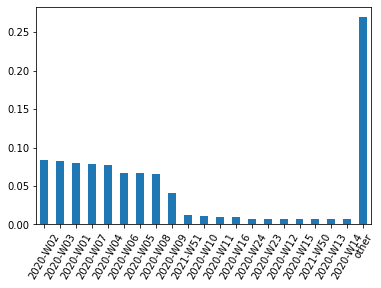

In [41]:
%matplotlib inline
s2 = pd.Series(null_vals_age_specific_cases['year_week'].unique())
prob = null_vals_age_specific_cases['year_week'].value_counts(normalize=True)
threshold = 0.005
mask = prob > threshold
tail_prob = prob.loc[~mask].sum()
prob = prob.loc[mask]
prob['other'] = tail_prob
prob.plot(kind='bar')
plt.xticks(rotation=60)
plt.show()

This emphasis the following assumptions:

1. Since Covid started appearing in February and March, previous weeks will have of course NaN values
2. some countries kept having NaN Values
3. Some values are missing like 2020W24 or 2020W23, also 2021W50 (reform)

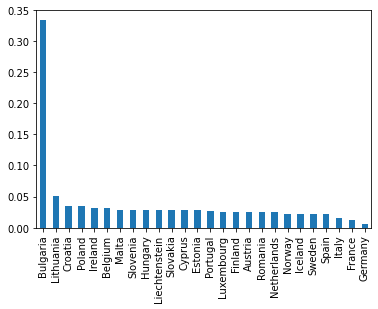

In [42]:
%matplotlib inline
prob = null_vals_age_specific_cases['country'].value_counts(normalize=True)
prob.plot(kind='bar')
plt.xticks(rotation=90)
plt.show()

In [43]:
null_vals_age_specific_cases[null_vals_age_specific_cases['country']=='Bulgaria'].shape

(624, 8)

618 is the number of lines for each country

In [44]:
null_vals_age_specific_cases[null_vals_age_specific_cases['country']=='Lithuania'].iloc[-5:]

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
11763,Lithuania,LT,2020-W12,80+yr,NaN,164546,NaN,TESSy COVID-19
11764,Lithuania,LT,2020-W13,80+yr,NaN,164546,NaN,TESSy COVID-19
11765,Lithuania,LT,2020-W14,80+yr,NaN,164546,NaN,TESSy COVID-19
11766,Lithuania,LT,2020-W15,80+yr,NaN,164546,NaN,TESSy COVID-19
11767,Lithuania,LT,2020-W16,80+yr,NaN,164546,NaN,TESSy COVID-19


interpretation

*Since we are going to merge this dataset to other ones, we only going to consider data starting from 2020W15*

After analysing the dataset, we came over the the **following conclusions**:
- All Balgaria's data is nan
- Lithuania data is nan until 2020W16 (included)
- Other countries have some missing values on some weeks but have previous ones

**Actions** to take :
- *Delete* Bulgaria rows 
- *Replace* Nan with *0* in the Lithuania dataset
- *Replace* Nan with *previous value* in other countries

In [45]:
age_specific_cases[(age_specific_cases['new_cases'].isna())&(age_specific_cases['year_week']=='2020-W16')]

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
1263,Bulgaria,BG,2020-W16,<15yr,NaN,1002258,NaN,TESSy COVID-19
1367,Bulgaria,BG,2020-W16,15-24yr,NaN,614613,NaN,TESSy COVID-19
1471,Bulgaria,BG,2020-W16,25-49yr,NaN,2402352,NaN,TESSy COVID-19
1575,Bulgaria,BG,2020-W16,50-64yr,NaN,1428171,NaN,TESSy COVID-19
1679,Bulgaria,BG,2020-W16,65-79yr,NaN,1165783,NaN,TESSy COVID-19
1783,Bulgaria,BG,2020-W16,80+yr,NaN,338305,NaN,TESSy COVID-19
4383,Estonia,EE,2020-W16,<15yr,NaN,218702,NaN,TESSy COVID-19
4487,Estonia,EE,2020-W16,15-24yr,NaN,125968,NaN,TESSy COVID-19
4591,Estonia,EE,2020-W16,25-49yr,NaN,460829,NaN,TESSy COVID-19
4695,Estonia,EE,2020-W16,50-64yr,NaN,257189,NaN,TESSy COVID-19


In [46]:
#Leave only data after the 2020-W15
age_specific_cases=age_specific_cases[age_specific_cases['year_week']>='2020-W15']

In [47]:
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
14,Austria,AT,2020-W15,<15yr,54.0,1283060,12.314311,TESSy COVID-19
15,Austria,AT,2020-W16,<15yr,14.0,1283060,5.299830,TESSy COVID-19
16,Austria,AT,2020-W17,<15yr,21.0,1283060,2.727854,TESSy COVID-19
17,Austria,AT,2020-W18,<15yr,20.0,1283060,3.195486,TESSy COVID-19
18,Austria,AT,2020-W19,<15yr,6.0,1283060,2.026406,TESSy COVID-19


In [48]:
no_bulgaria_age_specific_cases = age_specific_cases[age_specific_cases['country']!= 'Bulgaria'] 

In [49]:
no_bulgaria_age_specific_cases.shape

(15660, 8)

In [50]:
values = {'new_cases' : 0, 'rate_14_day_per_100k': 0}

no_bulgaria_age_specific_cases[no_bulgaria_age_specific_cases['country']=='Lithuania'] = no_bulgaria_age_specific_cases[no_bulgaria_age_specific_cases['country']=='Lithuania'].fillna(value=values) 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1715: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)


In [51]:
no_bulgaria_age_specific_cases[no_bulgaria_age_specific_cases['country']=='Lithuania'].head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
11246,Lithuania,LT,2020-W15,<15yr,0.0,422744,0.00000,TESSy COVID-19
11247,Lithuania,LT,2020-W16,<15yr,0.0,422744,0.00000,TESSy COVID-19
11248,Lithuania,LT,2020-W17,<15yr,0.0,422744,0.00000,TESSy COVID-19
11249,Lithuania,LT,2020-W18,<15yr,0.0,422744,0.00000,TESSy COVID-19
11250,Lithuania,LT,2020-W19,<15yr,1.0,422744,0.23655,TESSy COVID-19


In [52]:
no_bulgaria_age_specific_cases = no_bulgaria_age_specific_cases.fillna(method="ffill")

In [53]:
#Checking if we filled the missing values correctly with the previous ones
no_bulgaria_age_specific_cases[(no_bulgaria_age_specific_cases ['country']== 'Croatia') &(no_bulgaria_age_specific_cases ['year_week']>= '2020-W22') ].sort_values(['year_week','age_group']).head(12)

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
1997,Croatia,HR,2020-W22,15-24yr,0.0,436962,0.457706,TESSy COVID-19
2101,Croatia,HR,2020-W22,25-49yr,1.0,1319478,0.757875,TESSy COVID-19
2205,Croatia,HR,2020-W22,50-64yr,1.0,866470,0.577054,TESSy COVID-19
2309,Croatia,HR,2020-W22,65-79yr,0.0,631476,0.475077,TESSy COVID-19
2413,Croatia,HR,2020-W22,80+yr,3.0,222308,3.148785,TESSy COVID-19
1893,Croatia,HR,2020-W22,<15yr,0.0,581471,0.171978,TESSy COVID-19
1998,Croatia,HR,2020-W23,15-24yr,0.0,436962,0.457706,TESSy COVID-19
2102,Croatia,HR,2020-W23,25-49yr,1.0,1319478,0.757875,TESSy COVID-19
2206,Croatia,HR,2020-W23,50-64yr,1.0,866470,0.577054,TESSy COVID-19
2310,Croatia,HR,2020-W23,65-79yr,0.0,631476,0.475077,TESSy COVID-19


In [54]:
age_specific_cases = no_bulgaria_age_specific_cases

### Categorizing age_groupe to a numerical value

In [55]:
cleanup_age_group = {"age_group": {"<15yr": 0,
                                   "15-24yr": 1,
                                   "25-49yr": 2,
                                   "50-64yr": 3,
                                   "65-79yr": 4,
                                   "80+yr": 5,
                                   }
                     }
age_specific_cases = age_specific_cases.replace(cleanup_age_group)
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
14,Austria,AT,2020-W15,0,54.0,1283060,12.314311,TESSy COVID-19
15,Austria,AT,2020-W16,0,14.0,1283060,5.299830,TESSy COVID-19
16,Austria,AT,2020-W17,0,21.0,1283060,2.727854,TESSy COVID-19
17,Austria,AT,2020-W18,0,20.0,1283060,3.195486,TESSy COVID-19
18,Austria,AT,2020-W19,0,6.0,1283060,2.026406,TESSy COVID-19


## **testing Preprocessing**


In [56]:
testing = pd.read_csv(TESTING_DATASET)

In [57]:
testing.head()

,country,country_code,year_week,level,region,region_name,new_cases,tests_done,population,testing_rate,positivity_rate,testing_data_source
0,Austria,AT,2020-W15,national,AT,Austria,1838.0,12339,8901064.0,138.623877,14.895859,Manual webscraping
1,Austria,AT,2020-W16,national,AT,Austria,684.0,58488,8901064.0,657.089984,1.169471,Manual webscraping
2,Austria,AT,2020-W17,national,AT,Austria,448.0,33443,8901064.0,375.719128,1.339593,Manual webscraping
3,Austria,AT,2020-W18,national,AT,Austria,312.0,26598,8901064.0,298.818209,1.173021,Country website
4,Austria,AT,2020-W19,national,AT,Austria,264.0,42153,8901064.0,473.572598,0.626290,Country website


In [58]:
testing.describe()

,new_cases,tests_done,population,testing_rate,positivity_rate
count,11882.000000,1.188300e+04,1.188300e+04,11883.000000,11870.000000
mean,6662.480306,1.611402e+05,4.879654e+06,5955.092302,7.101763
std,21138.234860,4.453900e+05,1.168575e+07,11462.183834,11.763779
min,0.000000,1.000000e+00,3.874700e+04,0.010347,0.000000
25%,249.000000,9.380500e+03,4.177110e+05,1061.257017,1.096476
50%,1109.000000,3.169300e+04,1.404441e+06,2148.288714,3.410773
75%,4393.750000,1.340630e+05,4.488998e+06,4240.256213,8.913049
max,509629.000000,7.827648e+06,8.316671e+07,177264.346419,508.146640


In [59]:
testing.isnull().sum()

country                 0
country_code            0
year_week               0
level                   0
region                  0
region_name             0
new_cases               1
tests_done              0
population              0
testing_rate            0
positivity_rate        13
testing_data_source     0
dtype: int64

In [60]:
testing[testing['positivity_rate'].isna()]

,country,country_code,year_week,level,region,region_name,new_cases,tests_done,population,testing_rate,positivity_rate,testing_data_source
1235,Cyprus,CY,2020-W11,national,CY,Cyprus,44.0,14,888005.0,1.576568,NaN,Survey
1428,Denmark,DK,2020-W05,national,DK,Denmark,16.0,3,5822763.0,0.051522,NaN,Country website
1429,Denmark,DK,2020-W06,national,DK,Denmark,13.0,4,5822763.0,0.068696,NaN,Country website
1430,Denmark,DK,2020-W07,national,DK,Denmark,19.0,4,5822763.0,0.068696,NaN,Country website
1431,Denmark,DK,2020-W08,national,DK,Denmark,13.0,9,5822763.0,0.154566,NaN,Country website
2034,Finland,FI,2021-W51,national,FI,Finland,NaN,149799,5525292.0,2711.150831,NaN,TESSy
10244,Romania,RO,2020-W12,national,RO,Romania,372.0,2,19328838.0,0.010347,NaN,TESSy
10245,Romania,RO,2020-W13,national,RO,Romania,1376.0,12,19328838.0,0.062083,NaN,TESSy
10355,Slovakia,SK,2020-W23,national,SK,Slovakia,9.0,2,5457873.0,0.036644,NaN,Country GitHub
10359,Slovakia,SK,2020-W27,national,SK,Slovakia,116.0,12,5457873.0,0.219866,NaN,Country GitHub


In [61]:
testing = testing.fillna(method='ffill')


In [62]:
testing['year_week'].value_counts()

2021-W36    172
2021-W24    172
2021-W35    172
2021-W18    172
2021-W22    172
           ... 
2020-W05      7
2020-W04      2
2020-W01      2
2020-W03      1
2020-W02      1
Name: year_week, Length: 104, dtype: int64

In [63]:
testing = testing.groupby(['country', 'year_week'])['new_cases','tests_done','testing_rate','positivity_rate'].agg(['sum','max','min','mean']).reset_index()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  """Entry point for launching an IPython kernel.


In [64]:
testing.head()

country year_week new_cases  ... positivity_rate                      
                           sum  ...             max        min       mean
0  Austria  2020-W15    1838.0  ...       14.895859  14.895859  14.895859
1  Austria  2020-W16     684.0  ...        1.169471   1.169471   1.169471
2  Austria  2020-W17     448.0  ...        1.339593   1.339593   1.339593
3  Austria  2020-W18     312.0  ...        1.173021   1.173021   1.173021
4  Austria  2020-W19     264.0  ...        0.626290   0.626290   0.626290

[5 rows x 18 columns]

## **hospital_icu_admission Preprocessing**

In [65]:
hospital_icu_admission = pd.read_csv(HOSPITAL_ICU_ADMISSION)

In [66]:
hospital_icu_admission.head()

,country,indicator,date,year_week,value,source,url
0,Austria,Daily hospital occupancy,2020-04-01,2020-W14,856.0,Country_Website,https://covid19-dashboard.ages.at/dashboard_Ho...
1,Austria,Daily hospital occupancy,2020-04-02,2020-W14,823.0,Country_Website,https://covid19-dashboard.ages.at/dashboard_Ho...
2,Austria,Daily hospital occupancy,2020-04-03,2020-W14,829.0,Country_Website,https://covid19-dashboard.ages.at/dashboard_Ho...
3,Austria,Daily hospital occupancy,2020-04-04,2020-W14,826.0,Country_Website,https://covid19-dashboard.ages.at/dashboard_Ho...
4,Austria,Daily hospital occupancy,2020-04-05,2020-W14,712.0,Country_Website,https://covid19-dashboard.ages.at/dashboard_Ho...


In [67]:
hospital_icu_admission.describe()

,value
count,30935.000000
mean,1504.551484
std,4289.748677
min,0.000000
25%,21.000000
50%,159.000000
75%,851.000000
max,38507.000000


In [68]:
hospital_icu_admission.isnull().sum()

country         0
indicator       0
date            0
year_week       0
value           0
source          0
url          3130
dtype: int64

In [69]:
hospital_icu_admission = hospital_icu_admission.groupby(['country', 'year_week'])['value'].agg(['sum','max','min','mean']).reset_index().rename(columns={'sum':'admission_total','max':'admission_max','min':'admission_min','mean':'admission_mean'})

In [70]:
hospital_icu_admission.head()

,country,year_week,admission_total,admission_max,admission_min,admission_mean
0,Austria,2020-W14,5214.0,856.0,215.0,521.400000
1,Austria,2020-W15,7458.0,857.0,243.0,532.714286
2,Austria,2020-W16,6532.0,769.0,204.0,466.571429
3,Austria,2020-W17,4791.0,611.0,145.0,342.214286
4,Austria,2020-W18,3479.0,439.0,114.0,248.500000


## **country_measures Preprocessing**


- generate year_week columns 
- fill missing values date end by the actual date
- Categorize the Response_measure

In [71]:
country_measures = pd.read_csv(COUNTRY_MEASURES_DATASET)

In [72]:
country_measures.head()

,Country,Response_measure,date_start,date_end
0,Austria,AdaptationOfWorkplace,2020-03-16,2020-04-13
1,Austria,AdaptationOfWorkplace,2021-04-01,NaN
2,Austria,BanOnAllEvents,2020-11-03,2021-05-18
3,Austria,ClosDaycare,2020-03-16,2020-05-04
4,Austria,ClosDaycare,2020-11-17,2020-12-07


In [73]:
country_measures.describe()

,Country,Response_measure,date_start,date_end
count,2033,2033,2033,1692
unique,32,66,373,372
top,Netherlands,RestaurantsCafesPartial,2020-03-16,2020-05-31
freq,98,72,135,33


In [74]:
country_measures.isnull().sum()

Country               0
Response_measure      0
date_start            0
date_end            341
dtype: int64

In [75]:
country_measures['date_start'] = pd.to_datetime(country_measures['date_start'], format = '%Y-%m-%d')
country_measures['date_end'] = pd.to_datetime(country_measures['date_end'], format = '%Y-%m-%d')

In [76]:
country_measures.head()

,Country,Response_measure,date_start,date_end
0,Austria,AdaptationOfWorkplace,2020-03-16,2020-04-13
1,Austria,AdaptationOfWorkplace,2021-04-01,NaT
2,Austria,BanOnAllEvents,2020-11-03,2021-05-18
3,Austria,ClosDaycare,2020-03-16,2020-05-04
4,Austria,ClosDaycare,2020-11-17,2020-12-07


In [77]:
country_measures.isnull().sum()

Country               0
Response_measure      0
date_start            0
date_end            341
dtype: int64

### Handling missing values

In [78]:
country_measures['date_end'] = country_measures['date_end'].fillna(pd.to_datetime("today"))

### Creating year_week

In [79]:
country_measures = country_measures.reset_index()
country_measures.head()

,index,Country,Response_measure,date_start,date_end
0,0,Austria,AdaptationOfWorkplace,2020-03-16,2020-04-13 00:00:00.000000
1,1,Austria,AdaptationOfWorkplace,2021-04-01,2021-12-31 01:31:03.183658
2,2,Austria,BanOnAllEvents,2020-11-03,2021-05-18 00:00:00.000000
3,3,Austria,ClosDaycare,2020-03-16,2020-05-04 00:00:00.000000
4,4,Austria,ClosDaycare,2020-11-17,2020-12-07 00:00:00.000000


In [80]:
 #function that calculate the number of weeks in a periode between a date_start and date_end
#input = date_start , date_end
#output = {year-Wweek}
def set_country_measures_year_week (date_start, date_end):
  year_week = []
  while date_start < date_end:
    my_zero=''
    if date_start.week < 10:
      my_zero='0'
    year_week.append(str(date_start.year)+'-W'+my_zero+str(date_start.week))
    date_start = date_start + pd.Timedelta('7 days')
  #print(year_week)
  return year_week

In [81]:
#input : one row
#output : multiple row with additional column
country_measures['year_week'] = country_measures.apply(lambda x: set_country_measures_year_week(x['date_start'],x['date_end']),axis=1)
country_measures.head()

,index,Country,Response_measure,date_start,date_end,year_week
0,0,Austria,AdaptationOfWorkplace,2020-03-16,2020-04-13 00:00:00.000000,"[2020-W12, 2020-W13, 2020-W14, 2020-W15]"
1,1,Austria,AdaptationOfWorkplace,2021-04-01,2021-12-31 01:31:03.183658,"[2021-W13, 2021-W14, 2021-W15, 2021-W16, 2021-..."
2,2,Austria,BanOnAllEvents,2020-11-03,2021-05-18 00:00:00.000000,"[2020-W45, 2020-W46, 2020-W47, 2020-W48, 2020-..."
3,3,Austria,ClosDaycare,2020-03-16,2020-05-04 00:00:00.000000,"[2020-W12, 2020-W13, 2020-W14, 2020-W15, 2020-..."
4,4,Austria,ClosDaycare,2020-11-17,2020-12-07 00:00:00.000000,"[2020-W47, 2020-W48, 2020-W49]"


In [82]:
helper_df = country_measures.apply(lambda x : pd.Series(x['year_week']),axis=1)
helper_df[['index','Country','Response_measure']] = country_measures[['index','Country','Response_measure']]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  """Entry point for launching an IPython kernel.


In [83]:
helper_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,index,Country,Response_measure
0,2020-W12,2020-W13,2020-W14,2020-W15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,Austria,AdaptationOfWorkplace
1,2021-W13,2021-W14,2021-W15,2021-W16,2021-W17,2021-W18,2021-W19,2021-W20,2021-W21,2021-W22,2021-W23,2021-W24,2021-W25,2021-W26,2021-W27,2021-W28,2021-W29,2021-W30,2021-W31,2021-W32,2021-W33,2021-W34,2021-W35,2021-W36,2021-W37,2021-W38,2021-W39,2021-W40,2021-W41,2021-W42,2021-W43,2021-W44,2021-W45,2021-W46,2021-W47,2021-W48,2021-W49,2021-W50,2021-W51,2021-W52,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,Austria,AdaptationOfWorkplace
2,2020-W45,2020-W46,2020-W47,2020-W48,2020-W49,2020-W50,2020-W51,2020-W52,2020-W53,2021-W01,2021-W02,2021-W03,2021-W04,2021-W05,2021-W06,2021-W07,2021-W08,2021-W09,2021-W10,2021-W11,2021-W12,2021-W13,2021-W14,2021-W15,2021-W16,2021-W17,2021-W18,2021-W19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,Austria,BanOnAllEvents
3,2020-W12,2020-W13,2020-W14,2020-W15,2020-W16,2020-W17,2020-W18,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,Austria,ClosDaycare
4,2020-W47,2020-W48,2020-W49,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,Austria,ClosDaycare


In [84]:
year_week_country_measures = helper_df.set_index(['index','Country','Response_measure']).stack().reset_index()[['Country','Response_measure',0]].rename(columns={0:'year_week'})
year_week_country_measures['Country'].unique()

array(['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia',
       'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece',
       'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia',
       'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
       'Norway', 'Poland', 'Portugal', 'Romania', 'Slovakia', 'Slovenia',
       'Spain', 'Sweden', 'Switzerland', 'United Kingdom'], dtype=object)

In [85]:
year_week_country_measures.head(10)

,Country,Response_measure,year_week
0,Austria,AdaptationOfWorkplace,2020-W12
1,Austria,AdaptationOfWorkplace,2020-W13
2,Austria,AdaptationOfWorkplace,2020-W14
3,Austria,AdaptationOfWorkplace,2020-W15
4,Austria,AdaptationOfWorkplace,2021-W13
5,Austria,AdaptationOfWorkplace,2021-W14
6,Austria,AdaptationOfWorkplace,2021-W15
7,Austria,AdaptationOfWorkplace,2021-W16
8,Austria,AdaptationOfWorkplace,2021-W17
9,Austria,AdaptationOfWorkplace,2021-W18


In [86]:
year_week_country_measures.isnull().sum()

Country             0
Response_measure    0
year_week           0
dtype: int64

In [87]:
country_measures['Response_measure'].unique()

array(['AdaptationOfWorkplace', 'BanOnAllEvents', 'ClosDaycare',
       'ClosHigh', 'ClosHighPartial', 'ClosPrim', 'ClosPrimPartial',
       'ClosPubAny', 'ClosPubAnyPartial', 'ClosSec', 'ClosSecPartial',
       'EntertainmentVenues', 'EntertainmentVenuesPartial',
       'GymsSportsCentres', 'GymsSportsCentresPartial',
       'HotelsOtherAccommodation', 'HotelsOtherAccommodationPartial',
       'IndoorOver100', 'IndoorOver1000', 'IndoorOver50', 'IndoorOver500',
       'MasksMandatoryAllSpaces', 'MasksMandatoryClosedSpaces',
       'MasksMandatoryClosedSpacesPartial',
       'MasksVoluntaryClosedSpacesPartial', 'MassGather50',
       'MassGather50Partial', 'MassGatherAll', 'MassGatherAllPartial',
       'NonEssentialShops', 'NonEssentialShopsPartial', 'OutdoorOver100',
       'OutdoorOver1000', 'OutdoorOver500', 'PlaceOfWorship',
       'PlaceOfWorshipPartial', 'PrivateGatheringRestrictions',
       'PrivateGatheringRestrictionsPartial',
       'QuarantineForInternationalTravellers', 'R

### Categorize the Response_measure

The descriptive file emphasis the limitations in the dataset, due to heterogeneity in term of the definitions of different aspects given by each country, these aspects are mainly the the physical distancing policies, the level of enforcement of measures. In short words, the present data gives an overview on a national level, thus, any comparison won't be truthful and accurate.

Furthermore, this dataset is extracted from different official sources, there may be some delays in their implementations.

In addition, availability of data is also a challenge, since some sources delete data related to measures that are no longer in force.

Working with such a dataset is challenging, ...


Features Extraction

In [88]:
#input dataframe
#output dataframe with 41 additional columns

#we will need :
#dict of the 41 columns and their respective conditions
#dict = {'column_name1':{'opt1':'val1',
#                      'opt2':'val2',
#                      ...
#                       },
#        ...
#       }
#iterate on the dict.keys()
##each iteration : add the column with specific conditions (  year_week_country_measures['column_name1'] =  year_week_country_measures.apply(set_val_function,axis=1) )

In [89]:
new_columns_dict = {
    'SHM': {
        'StayHomeOrder':4,     
        'RegionalStayHomeOrder ':3,     
        'StayHomeGen ':2,     
        'StayHomeRiskG ':1,     
        'StayHomeOrderPartial':4,     
        'RegionalStayHomeOrderPartial ':3,     
        'StayHomeGenPartial ':2,     
        'StayHomeRiskGPartial ':1
        },
    'SMHT':{
        'StayHomeOrder':1,     
        'RegionalStayHomeOrder ':1,     
        'StayHomeGen ':1,     
        'StayHomeRiskG ':1,     
        'StayHomeOrderPartial':0,     
        'RegionalStayHomeOrderPartial ':0,     
        'StayHomeGenPartial ':0,     
        'StayHomeRiskGPartial ':0
    },
    'EINCM':{
        'ClosDayCare':1,     
        'ClosPrim':0,     
        'ClosSec ':0,     
        'ClosHigh ':0,     
        'ClosDayCarePartial':1,     
        'ClosPrimPartial':0,     
        'ClosSecPartial ':0,     
        'ClosHighPartial ':0
    },
    'EIPCM':{
        'ClosDayCare':0,     
        'ClosPrim':1,     
        'ClosSec ':0,     
        'ClosHigh ':0,     
        'ClosDayCarePartial':0,     
        'ClosPrimPartial':1,     
        'ClosSecPartial ':0,     
        'ClosHighPartial ':0
    },
    'EISCM':{
        'ClosDayCare':0,     
        'ClosPrim':0,     
        'ClosSec ':1,     
        'ClosHigh ':0,     
        'ClosDayCarePartial':0,     
        'ClosPrimPartial':0,     
        'ClosSecPartial ':1,     
        'ClosHighPartial ':0
    },
    'EIHCM':{
        'ClosDayCare':0,     
        'ClosPrim':0,     
        'ClosSec ':0,     
        'ClosHigh ':1,     
        'ClosDayCarePartial':0,     
        'ClosPrimPartial':0,     
        'ClosSecPartial ':0,     
        'ClosHighPartial ':1
    },
    'EICMT':{
        'ClosDayCare':1,     
        'ClosPrim':1,     
        'ClosSec ':1,     
        'ClosHigh ':1,     
        'ClosDayCarePartial':0,     
        'ClosPrimPartial':0,     
        'ClosSecPartial ':0,     
        'ClosHighPartial ':0     
    },
    
        'MGEM':{
            'MassGatherAll':0,     
            'BanOnAllEvents':1,     
            'IndoorOver50':1,     
            'IndoorOver100':1,     
            'IndoorOver500':1,     
            'IndoorOver1000':1,     
            'OutdoorOver50':1,     
            'OutdoorOver100':1,     
            'OutdoorOver500':1,     
            'OutdoorOver1000':1,     
            'MassGatherAllPartial':0,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver50Partial':1,     
            'IndoorOver100Partial':1,     
            'IndoorOver500Partial':1,     
            'IndoorOver1000Partial':1,
            'OutdoorOver50Partial':1,     
            'OutdoorOver100Partial':1,     
            'OutdoorOver500Partial':1,     
            'OutdoorOver1000Partial':1
        },
        'MGIM':{
            'MassGatherAll':1,     
            'BanOnAllEvents':1,     
            'IndoorOver50':1,     
            'IndoorOver100':1,     
            'IndoorOver500':1,     
            'IndoorOver1000':1,
            'OutdoorOver50':0,     
            'OutdoorOver100':0,     
            'OutdoorOver500':0,     
            'OutdoorOver1000':0,     
            'MassGatherAllPartial':1,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver50Partial':1,     
            'IndoorOver100Partial':1,     
            'IndoorOver500Partial':1,     
            'IndoorOver1000Partial':1,
            'OutdoorOver50Partial':1,     
            'OutdoorOver100Partial':1,     
            'OutdoorOver500Partial':1,     
            'OutdoorOver1000Partial':1,
        },
        'MGOM':{
            'MassGatherAll':1,     
            'BanOnAllEvents':1,     
            'IndoorOver50':0,     
            'IndoorOver100':0,     
            'IndoorOver500':0,     
            'IndoorOver1000':0,     
            'OutdoorOver50':1,     
            'OutdoorOver100':1,     
            'OutdoorOver500':1,     
            'OutdoorOver1000':1,     
            'MassGatherAllPartial':0,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver50Partial':0,     
            'IndoorOver100Partial':0,     
            'IndoorOver500Partial':0,     
            'IndoorOver1000Partial':0,
            'OutdoorOver50Partial':1,     
            'OutdoorOver100Partial':1,     
            'OutdoorOver500Partial':1,     
            'OutdoorOver1000Partial':1
        },
        'MGSO50M': {
            'MassGatherAll':1,     
            'BanOnAllEvents':1,     
            'IndoorOver50':1,          
            'OutdoorOver50':1,     
            'MassGatherAllPartial':1,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver50Partial':1,     
            'OutdoorOver50Partial':1,     
            
        },
        'MGSO100M': {
            'MassGatherAll':1,     
            'BanOnAllEvents':1,     
            'IndoorOver100':1,     
            'OutdoorOver100':1,     
            'MassGatherAllPartial':1,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver100Partial':1,     
            'OutdoorOver100Partial':1,     
            
        },
        'MGSO500M': {
            'MassGatherAll':1,     
            'BanOnAllEvents':1,         
            'IndoorOver500':1,     
            'OutdoorOver500':1,     
            'MassGatherAllPartial':1,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver500Partial':1,     
            'OutdoorOver500Partial':1,     
        },
        'MGSO1000M': {
            'MassGatherAll':1,     
            'BanOnAllEvents':1,        
            'IndoorOver1000':1,     
            'OutdoorOver1000':1,     
            'MassGatherAllPartial':1,     
            'BanOnAllEventsPartial':1,     
            'IndoorOver1000Partial':1,
            'OutdoorOver1000Partial':1,
        },
        'MGMT': {
            'MassGatherAll':1,     
            'BanOnAllEvents':1,     
            'IndoorOver50':1,     
            'IndoorOver100':1,     
            'IndoorOver500':1,     
            'IndoorOver1000':1,     
            'OutdoorOver50':1,     
            'OutdoorOver100':1,     
            'OutdoorOver500':1,     
            'OutdoorOver1000':1,     
            'MassGatherAllPartial':0,     
            'BanOnAllEventsPartial':0,     
            'IndoorOver50Partial':0,     
            'IndoorOver100Partial':0,     
            'IndoorOver500Partial':0,     
            'IndoorOver1000Partial':0
        },
        'WM':{
            'WorkplaceClosures':1,     
            'AdaptationOfWorkplace':0,     
            'WorkplaceClosuresPartial':1,     
            'AdaptationOfWorkplacePartial':0,     
        },
        'WMT':{
            'WorkplaceClosures':1,     
            'AdaptationOfWorkplace':1,     
            'WorkplaceClosuresPartial':0,     
            'AdaptationOfWorkplacePartial':0,     
        },
        'TWM':{
            'Teleworking':1,
            'TeleworkingPartial':1
        },
        'TWMT':{
            'Teleworking':1,
            'TeleworkingPartail':0
        },
    'MOM':{
        'MasksVoluntaryAllSpaces':0,
        'MasksMandatoryAllSpaces':1,
        'MasksVoluntaryAllSpacesPartial':0,
        'MasksMandatoryAllSpacesPartial':1,
    },
    'MOMT':{
        'MasksVoluntaryAllSpaces':1,
        'MasksMandatoryAllSpaces':1,
        'MasksVoluntaryAllSpacesPartial':0,
        'MasksMandatoryAllSpacesPartial':0,
    },
    'MIM':{
        'MasksVoluntaryClosedSpaces':0,
        'MasksMandatoryClosedSpaces':1,
        'MasksVoluntaryClosedSpacesPartial':0,
        'MasksMandatoryClosedSpacesPartial':1,
    },
    'MIMT':{
        'MasksVoluntaryClosedSpaces':1,
        'MasksMandatoryClosedSpaces':1,
        'MasksVoluntaryClosedSpacesPartial':0,
        'MasksMandatoryClosedSpacesPartial':0
    },
    'EVCM':{
        'ClosPubAny':1,
        'EntertainmentVenues':1,
        'ClosPubAnyPartial':1,
        'EntertainmentVenuesPartial':1,
    },
    'EVCMT':{
        'ClosPubAny':1,
        'EntertainmentVenues':1,
        'ClosPubAnyPartial':0,
        'EntertainmentVenuesPartial':0,
    },
    'PTCM':{
        'ClosPubAny':1,
        'ClosureOfPublicTransport':1,
        'ClosPubAnyPartial':1,
        'ClosureOfPublicTransportPartial':1,
    },
    'PTCMT':{
        'ClosPubAny':1,
        'ClosureOfPublicTransport':1,
        'ClosPubAnyPartial':0,
        'ClosureOfPublicTransportPartial':0,
    },
    'GCM':{
        'ClosPubAny':1,
        'GymsSportsCentres':1,
        'ClosPubAnyPartial':1,
        'GymsSportsCentresPartial':1,
    },
    'GCMT':{
        'ClosPubAny':1,
        'GymsSportsCentres':1,
        'ClosPubAnyPartial':0,
        'GymsSportsCentresPartial':0,
    },
    'HACM':{
        'ClosPubAny':1,
        'HotelsAccommodation':1,
        'ClosPubAnyPartial':1,
        'HotelsAccommodationPartial':1,
    },
    'HACMT':{
        'ClosPubAny':1,
        'HotelsAccommodation':1,
        'ClosPubAnyPartial':0,
        'HotelsAccommodationPartial':0,
    },
    'NESCM':{
        'ClosPubAny':1,
        'NonEssentialShops':1,
        'ClosPubAnyPartial':1,
        'NonEssentialShopsPartial':1,
    },
    'NESCMT':{
        'ClosPubAny':1,
        'NonEssentialShops':1,
        'ClosPubAnyPartial':0,
        'NonEssentialShopsPartial':0,
    },
    'POWCM':{
        'ClosPubAny':1,
        'PlaceOfWorship':1,
        'ClosPubAnyPartial':1,
        'PlaceOfWorshipPartial':1,
    },
    'POWCMT':{
        'ClosPubAny':1,
        'PlaceOfWorship':1,
        'ClosPubAnyPartial':0,
        'PlaceOfWorshipPartial':0,
    },
    'RCCM':{
        'ClosPubAny':1,
        'RestaurantsCafes':1,
        'ClosPubAnyPartial':1,
        'RestaurantsCafesPartial':1,
    },
    'RCCMT':{
        'ClosPubAny':1,
        'RestaurantsCafes':1,
        'ClosPubAnyPartial':0,
        'RestaurantsCafesPartial':0,
    },
    'SCM':{
        'SocialCircle':1,
        'SocialCirclePartial':1
    },
    'SCMT':{
        'SocialCircle':1,
        'SocialCirclePartial':0
    },
    'PGRM':{
        'PrivateGatheringRestrictions':1,
        'PrivateGatheringRestrictionsPartial':1
    },
    'PGRMT':{
        'PrivateGatheringRestrictions':1,
        'PrivateGatheringRestrictionsPartial':0
    }
}

In [90]:
for column_name in new_columns_dict.keys():
  current_column = new_columns_dict[column_name]
  def set_new_column_values(x):
    if x['Response_measure'] in current_column.keys():
      return current_column[x['Response_measure']]
    else:
      return 0
  year_week_country_measures[column_name] = year_week_country_measures.apply(set_new_column_values,axis=1)

In [91]:
year_week_country_measures[(year_week_country_measures['Country']=='Austria')&(year_week_country_measures['year_week']=='2021-W01')]

,Country,Response_measure,year_week,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT
53,Austria,BanOnAllEvents,2021-W01,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
120,Austria,ClosHighPartial,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
177,Austria,ClosPrim,2021-W01,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
200,Austria,ClosPubAny,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0
294,Austria,ClosSec,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
341,Austria,EntertainmentVenues,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
402,Austria,GymsSportsCentres,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
472,Austria,HotelsOtherAccommodation,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
575,Austria,MasksMandatoryAllSpaces,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
661,Austria,MassGather50,2021-W01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [92]:
country_measures = year_week_country_measures.groupby(['Country','year_week'])[list(new_columns_dict.keys())].agg('max').reset_index()

In [93]:
country_measures.head()

,Country,year_week,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT
0,Austria,2020-W11,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Austria,2020-W12,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
2,Austria,2020-W13,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
3,Austria,2020-W14,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
4,Austria,2020-W15,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1


## Merging all the five datasets

### Check Data (column names)

In [94]:
daily_cases.head()

countriesAndTerritories year_week    cases  ... deaths                 
                                         sum  ...    max   min    average
0                 Austria  2021-W09  13427.0  ...   22.0  15.0  18.166667
1                 Austria  2021-W10  18468.0  ...   26.0  18.0  21.714286
2                 Austria  2021-W11  20737.0  ...   32.0  22.0  26.285714
3                 Austria  2021-W12  22100.0  ...   30.0  18.0  24.714286
4                 Austria  2021-W13  21652.0  ...   34.0  23.0  28.428571

[5 rows x 10 columns]

In [95]:
# Better if we keep just one level of columns
daily_cases.columns = ['_'.join(col) for col in daily_cases.columns]

In [96]:
daily_cases = daily_cases.rename(columns={'countriesAndTerritories_':'country', 'year_week_':'year_week'})

In [97]:
daily_cases.head()

,country,year_week,cases_sum,cases_max,cases_min,cases_average,deaths_sum,deaths_max,deaths_min,deaths_average
0,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667
1,Austria,2021-W10,18468.0,3325.0,1965.0,2638.285714,152.0,26.0,18.0,21.714286
2,Austria,2021-W11,20737.0,4051.0,1910.0,2962.428571,184.0,32.0,22.0,26.285714
3,Austria,2021-W12,22100.0,3896.0,2306.0,3157.142857,173.0,30.0,18.0,24.714286
4,Austria,2021-W13,21652.0,3693.0,2667.0,3093.142857,199.0,34.0,23.0,28.428571


In [98]:
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,source
14,Austria,AT,2020-W15,0,54.0,1283060,12.314311,TESSy COVID-19
15,Austria,AT,2020-W16,0,14.0,1283060,5.299830,TESSy COVID-19
16,Austria,AT,2020-W17,0,21.0,1283060,2.727854,TESSy COVID-19
17,Austria,AT,2020-W18,0,20.0,1283060,3.195486,TESSy COVID-19
18,Austria,AT,2020-W19,0,6.0,1283060,2.026406,TESSy COVID-19


In [99]:
columns_to_keep = age_specific_cases.columns.to_list()[0:-1]

In [100]:
age_specific_cases = age_specific_cases[columns_to_keep]

In [101]:
age_specific_cases.head()

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k
14,Austria,AT,2020-W15,0,54.0,1283060,12.314311
15,Austria,AT,2020-W16,0,14.0,1283060,5.299830
16,Austria,AT,2020-W17,0,21.0,1283060,2.727854
17,Austria,AT,2020-W18,0,20.0,1283060,3.195486
18,Austria,AT,2020-W19,0,6.0,1283060,2.026406


In [102]:
testing.head()

country year_week new_cases  ... positivity_rate                      
                           sum  ...             max        min       mean
0  Austria  2020-W15    1838.0  ...       14.895859  14.895859  14.895859
1  Austria  2020-W16     684.0  ...        1.169471   1.169471   1.169471
2  Austria  2020-W17     448.0  ...        1.339593   1.339593   1.339593
3  Austria  2020-W18     312.0  ...        1.173021   1.173021   1.173021
4  Austria  2020-W19     264.0  ...        0.626290   0.626290   0.626290

[5 rows x 18 columns]

In [103]:
# Better if we keep just one level of columns
testing.columns = ['_'.join(col) for col in testing.columns]

In [104]:
testing.head()

,country_,year_week_,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean
0,Austria,2020-W15,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859
1,Austria,2020-W16,684.0,684.0,684.0,684.0,58488,58488,58488,58488.0,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471
2,Austria,2020-W17,448.0,448.0,448.0,448.0,33443,33443,33443,33443.0,375.719128,375.719128,375.719128,375.719128,1.339593,1.339593,1.339593,1.339593
3,Austria,2020-W18,312.0,312.0,312.0,312.0,26598,26598,26598,26598.0,298.818209,298.818209,298.818209,298.818209,1.173021,1.173021,1.173021,1.173021
4,Austria,2020-W19,264.0,264.0,264.0,264.0,42153,42153,42153,42153.0,473.572598,473.572598,473.572598,473.572598,0.626290,0.626290,0.626290,0.626290


In [105]:
testing = testing.rename(columns={'country_':'country', 'year_week_':'year_week'})

In [106]:
testing.head()

,country,year_week,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean
0,Austria,2020-W15,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859
1,Austria,2020-W16,684.0,684.0,684.0,684.0,58488,58488,58488,58488.0,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471
2,Austria,2020-W17,448.0,448.0,448.0,448.0,33443,33443,33443,33443.0,375.719128,375.719128,375.719128,375.719128,1.339593,1.339593,1.339593,1.339593
3,Austria,2020-W18,312.0,312.0,312.0,312.0,26598,26598,26598,26598.0,298.818209,298.818209,298.818209,298.818209,1.173021,1.173021,1.173021,1.173021
4,Austria,2020-W19,264.0,264.0,264.0,264.0,42153,42153,42153,42153.0,473.572598,473.572598,473.572598,473.572598,0.626290,0.626290,0.626290,0.626290


In [107]:
testing.head()

,country,year_week,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean
0,Austria,2020-W15,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859
1,Austria,2020-W16,684.0,684.0,684.0,684.0,58488,58488,58488,58488.0,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471
2,Austria,2020-W17,448.0,448.0,448.0,448.0,33443,33443,33443,33443.0,375.719128,375.719128,375.719128,375.719128,1.339593,1.339593,1.339593,1.339593
3,Austria,2020-W18,312.0,312.0,312.0,312.0,26598,26598,26598,26598.0,298.818209,298.818209,298.818209,298.818209,1.173021,1.173021,1.173021,1.173021
4,Austria,2020-W19,264.0,264.0,264.0,264.0,42153,42153,42153,42153.0,473.572598,473.572598,473.572598,473.572598,0.626290,0.626290,0.626290,0.626290


In [108]:
hospital_icu_admission.head()

,country,year_week,admission_total,admission_max,admission_min,admission_mean
0,Austria,2020-W14,5214.0,856.0,215.0,521.400000
1,Austria,2020-W15,7458.0,857.0,243.0,532.714286
2,Austria,2020-W16,6532.0,769.0,204.0,466.571429
3,Austria,2020-W17,4791.0,611.0,145.0,342.214286
4,Austria,2020-W18,3479.0,439.0,114.0,248.500000


In [109]:
country_measures.head()

,Country,year_week,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT
0,Austria,2020-W11,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Austria,2020-W12,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
2,Austria,2020-W13,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
3,Austria,2020-W14,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
4,Austria,2020-W15,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1


In [110]:
country_measures = country_measures.rename(columns={'Country':'country'})

In [111]:
country_measures.head()

,country,year_week,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT
0,Austria,2020-W11,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Austria,2020-W12,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
2,Austria,2020-W13,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
3,Austria,2020-W14,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1
4,Austria,2020-W15,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1


### Applying merge

Since daily_cases dataset have only data starting from 2021-W09, we are going to create two merges:
1. With daily_cases
2. Without daily_cases

In [112]:
#with daily_cases
with_dc_df = daily_cases.merge(age_specific_cases, on=['country','year_week']).merge(country_measures, on=['country','year_week']).merge(testing, on=['country','year_week']).merge(hospital_icu_admission, on=['country','year_week'])

In [113]:
with_dc_df.head(6)

,country,year_week,cases_sum,cases_max,cases_min,cases_average,deaths_sum,deaths_max,deaths_min,deaths_average,country_code,age_group,new_cases,population,rate_14_day_per_100k,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean
0,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,0,2476.0,1283060,355.868003,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286
1,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,1,2388.0,955625,459.385219,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286
2,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,2,6413.0,3006228,399.803342,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286
3,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,3,3312.0,1962524,317.703121,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286
4,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,4,1197.0,1219580,185.637679,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286
5,Austria,2021-W09,13427.0,2846.0,1148.0,2237.833333,109.0,22.0,15.0,18.166667,AT,5,538.0,474047,220.864176,4,0,0,0,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,1,1,0,0,1,0,1,0,1,1,1,0,1,0,1,0,1,1,1,1,0,0,32681.0,16324.0,305.0,3268.1,3303734,1651867,38228,330373.4,185019.763883,22883.247624,6815.001275,18501.976388,10.782567,2.69436,0.356683,1.078257,10013.0,1155.0,296.0,715.214286


In [114]:
without_dc_df = age_specific_cases.merge(country_measures, on=['country','year_week']).merge(testing, on=['country','year_week']).merge(hospital_icu_admission, on=['country','year_week'])

In [115]:
without_dc_df.iloc[-12:]

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean
14556,Sweden,SE,2021-W50,0,5943.0,1834821,590.956829,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14557,Sweden,SE,2021-W50,1,1975.0,1156608,298.113103,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14558,Sweden,SE,2021-W50,2,10923.0,3404540,553.055626,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14559,Sweden,SE,2021-W50,3,4380.0,1866253,400.320857,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14560,Sweden,SE,2021-W50,4,1137.0,1529061,146.560536,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14561,Sweden,SE,2021-W50,5,169.0,536306,64.328947,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,24542.0,24542.0,24542.0,24542.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022
14562,Sweden,SE,2021-W51,0,4724.0,1834821,581.364613,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28055.0,28055.0,28055.0,28055.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614
14563,Sweden,SE,2021-W51,1,3450.0,1156608,469.043963,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28055.0,28055.0,28055.0,28055.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614
14564,Sweden,SE,2021-W51,2,13359.0,3404540,713.224107,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28055.0,28055.0,28055.0,28055.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614
14565,Sweden,SE,2021-W51,3,5130.0,1866253,509.577212,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,28055.0,28055.0,28055.0,28055.0,386528,386528,386528,386528.0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614


In [116]:
risk_dict = {0:{
                  'color' : 'green',
                  'color_code' : '#00FF00',
                  'daily_cases_per_capita_risk' : 'no risk',
                  'positivity_rate' : 'Adequate testing',
                },
              1:{
                  'color' : 'yellow',
                  'color_code' : '#FFD700',
                  'daily_cases_per_capita_risk' : 'low risk',
                  'positivity_rate' : 'High rate of testing',
                },
              2:{
                  'color': 'orange',
                  'color_code' : '#FF4500',
                  'daily_cases_per_capita_risk' : 'medium risk',
                  'positivity_rate' : 'Low rate of testing',
                },
              3:{
                  'color': 'red',
                  'color_code' : '#FF0000',
                  'daily_cases_per_capita_risk' : 'high risk',
                  'positivity_rate' : 'Inadequate testing',
                },
              4:{
                  'color': 'crimson',
                  'color_code' : '#DC143C',
                  'daily_cases_per_capita_risk' : 'severe outbreak',
                }
              }
def daily_cases_per_capita_risk(x):
  if x < 1:
    return 0
  elif x < 10:
    return 1
  elif x < 25:
    return 2
  elif x < 75:
    return 3
  else:
    return 4

def positivity_rate(x):
  if x < 3:
    return 0
  elif x < 10:
    return 1
  elif x < 20:
    return 2
  else:
    return 3

def get_color_code(index):
  global risk_dict
  return risk_dict[index].color_code
def get_positivity_rate_risk(index):
  global risk_dict
  return risk_dict[index].positivity_rate
def get_daily_cases_per_capita_risk(index):
  global risk_dict
  return risk_dict[index].daily_cases_per_capita_risk


In [117]:
without_dc_df['daily_cases_per_capita_risk'] = without_dc_df['rate_14_day_per_100k'].apply(daily_cases_per_capita_risk)
without_dc_df['positivity_rate'] = without_dc_df['positivity_rate_mean'].apply(positivity_rate)
without_dc_df.head(3)

,country,country_code,year_week,age_group,new_cases,population,rate_14_day_per_100k,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases_sum,new_cases_max,new_cases_min,new_cases_mean,tests_done_sum,tests_done_max,tests_done_min,tests_done_mean,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate
0,Austria,AT,2020-W15,0,54.0,1283060,12.314311,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,2,2
1,Austria,AT,2020-W15,1,178.0,955625,50.856769,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2
2,Austria,AT,2020-W15,2,592.0,3006228,56.050306,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,1838.0,1838.0,1838.0,1838.0,12339,12339,12339,12339.0,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2


In [118]:
columns_to_keep = ['country','year_week','age_group','new_cases','rate_14_day_per_100k','population','SHM','SMHT','EINCM','EIPCM','EISCM','EIHCM','EICMT','MGEM','MGIM','MGOM','MGSO50M','MGSO100M','MGSO500M','MGSO1000M','MGMT','WM','WMT','TWM','TWMT','MOM','MOMT','MIM','MIMT','EVCM','EVCMT','PTCM','PTCMT','GCM','GCMT','HACM','HACMT','NESCM','NESCMT','POWCM','POWCMT','RCCM','RCCMT','SCM','SCMT','PGRM','PGRMT','testing_rate_sum','testing_rate_max','testing_rate_min','testing_rate_mean','positivity_rate_sum','positivity_rate_max','positivity_rate_min','positivity_rate_mean','admission_total','admission_max','admission_min','admission_mean','daily_cases_per_capita_risk','positivity_rate']
without_dc_df = without_dc_df[columns_to_keep]
without_dc_df.head(15)

,country,year_week,age_group,new_cases,rate_14_day_per_100k,population,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate
0,Austria,2020-W15,0,54.0,12.314311,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,2,2
1,Austria,2020-W15,1,178.0,50.856769,955625,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2
2,Austria,2020-W15,2,592.0,56.050306,3006228,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2
3,Austria,2020-W15,3,523.0,69.808063,1962524,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2
4,Austria,2020-W15,4,233.0,54.280982,1219580,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2
5,Austria,2020-W15,5,258.0,125.093081,474047,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,4,2
6,Austria,2020-W16,0,14.0,5.299830,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.0,769.0,204.0,466.571429,1,0
7,Austria,2020-W16,1,54.0,24.277305,955625,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.0,769.0,204.0,466.571429,2,0
8,Austria,2020-W16,2,216.0,26.877536,3006228,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.0,769.0,204.0,466.571429,3,0
9,Austria,2020-W16,3,136.0,33.579207,1962524,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.0,769.0,204.0,466.571429,3,0


### Adding 1 metric

As planned, we also want to solve a classification problem that determines risk rate in a specific region or in all regions. For this matter, we already have two metrics which are rate_14_day_per_100k and positivity_rate, thus, we still need 1 more metric which is **Case fatality**.

This would also help the regression problem in predicting new cases number.

One limitation is that deaths cases is only available on daily_cases dataset which doesn't start until 2nd March 2021 and also doesn't take age_group into consideration.

# Application of predictive models

## Data Normalization

In [119]:
#Run Once
from sklearn.preprocessing import LabelEncoder
country_encoder = LabelEncoder()
country_encoder.fit(without_dc_df['country'])
without_dc_df['country'] = country_encoder.transform(without_dc_df['country'])
without_dc_df

,country,year_week,age_group,new_cases,rate_14_day_per_100k,population,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate
0,0,2020-W15,0,54.0,12.314311,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,2,2
1,0,2020-W15,1,178.0,50.856769,955625,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,3,2
2,0,2020-W15,2,592.0,56.050306,3006228,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,3,2
3,0,2020-W15,3,523.0,69.808063,1962524,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,3,2
4,0,2020-W15,4,233.0,54.280982,1219580,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,28,2021-W51,1,3450.0,469.043963,1156608,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614,4,1
14564,28,2021-W51,2,13359.0,713.224107,3404540,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614,4,1
14565,28,2021-W51,3,5130.0,509.577212,1866253,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614,4,1
14566,28,2021-W51,4,1135.0,148.587924,1529061,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3742.674113,3742.674113,3742.674113,3742.674113,7.258206,7.258206,7.258206,7.258206,778.474457,519.0,0.474457,194.618614,4,1


In [120]:
#we used year_week in previous sections, now we are going to create a year and a week column in order to have a numerical value  
without_dc_df['year'] = without_dc_df['year_week'].apply(lambda x: int(x[0:4]))
without_dc_df['week'] = without_dc_df['year_week'].apply(lambda x: int(x[6:8]))
without_dc_df = without_dc_df.drop(['year_week'],axis=1)
without_dc_df.head()

,country,age_group,new_cases,rate_14_day_per_100k,population,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate,year,week
0,0,0,54.0,12.314311,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,2,2,2020,15
1,0,1,178.0,50.856769,955625,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2,2020,15
2,0,2,592.0,56.050306,3006228,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2,2020,15
3,0,3,523.0,69.808063,1962524,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2,2020,15
4,0,4,233.0,54.280982,1219580,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,3,2,2020,15


In [121]:
without_dc_df.isnull().sum().value_counts()

0    62
dtype: int64

In [122]:
without_dc_df = without_dc_df.sort_values(['country','age_group'])
without_dc_df

,country,age_group,new_cases,rate_14_day_per_100k,population,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate,year,week
0,0,0,54.0,12.314311,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.000000,857.0,243.000000,532.714286,2,2,2020,15
6,0,0,14.0,5.299830,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.000000,769.0,204.000000,466.571429,1,0,2020,16
12,0,0,21.0,2.727854,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,375.719128,375.719128,375.719128,375.719128,1.339593,1.339593,1.339593,1.339593,4791.000000,611.0,145.000000,342.214286,1,0,2020,17
18,0,0,20.0,3.195486,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,298.818209,298.818209,298.818209,298.818209,1.173021,1.173021,1.173021,1.173021,3479.000000,439.0,114.000000,248.500000,1,0,2020,18
24,0,0,6.0,2.026406,1283060,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,473.572598,473.572598,473.572598,473.572598,0.626290,0.626290,0.626290,0.626290,2555.000000,321.0,72.000000,182.500000,1,0,2020,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14543,28,5,159.0,49.412089,536306,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2191.111594,2191.111594,2191.111594,2191.111594,5.265833,5.265833,5.265833,5.265833,2255.338898,307.0,0.338898,150.355927,3,1,2021,47
14549,28,5,151.0,57.802822,536306,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2652.961887,2652.961887,2652.961887,2652.961887,5.036735,5.036735,5.036735,5.036735,2593.309850,344.0,0.309850,172.887323,3,1,2021,48
14555,28,5,176.0,60.972654,536306,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3252.995447,3252.995447,3252.995447,3252.995447,5.552513,5.552513,5.552513,5.552513,3286.445409,451.0,0.445409,219.096361,3,1,2021,49
14561,28,5,169.0,64.328947,536306,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3742.674113,3742.674113,3742.674113,3742.674113,6.349346,6.349346,6.349346,6.349346,4044.600334,526.0,0.600334,269.640022,3,1,2021,50


In [123]:
without_dc_df[(without_dc_df['country']==0)&(without_dc_df['age_group']==0)]

,country,age_group,new_cases,rate_14_day_per_100k,population,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,testing_rate_sum,testing_rate_max,testing_rate_min,testing_rate_mean,positivity_rate_sum,positivity_rate_max,positivity_rate_min,positivity_rate_mean,admission_total,admission_max,admission_min,admission_mean,daily_cases_per_capita_risk,positivity_rate,year,week
0,0,0,54.0,12.314311,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,138.623877,138.623877,138.623877,138.623877,14.895859,14.895859,14.895859,14.895859,7458.0,857.0,243.0,532.714286,2,2,2020,15
6,0,0,14.0,5.299830,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,657.089984,657.089984,657.089984,657.089984,1.169471,1.169471,1.169471,1.169471,6532.0,769.0,204.0,466.571429,1,0,2020,16
12,0,0,21.0,2.727854,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,375.719128,375.719128,375.719128,375.719128,1.339593,1.339593,1.339593,1.339593,4791.0,611.0,145.0,342.214286,1,0,2020,17
18,0,0,20.0,3.195486,1283060,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,298.818209,298.818209,298.818209,298.818209,1.173021,1.173021,1.173021,1.173021,3479.0,439.0,114.0,248.500000,1,0,2020,18
24,0,0,6.0,2.026406,1283060,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,473.572598,473.572598,473.572598,473.572598,0.626290,0.626290,0.626290,0.626290,2555.0,321.0,72.0,182.500000,1,0,2020,19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
510,0,0,19013.0,3114.273689,1283060,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,838328.799407,147471.371406,60519.140504,83832.879941,13.239448,1.964200,0.330813,1.323945,22532.0,2658.0,572.0,1609.428571,4,0,2021,47
516,0,0,11356.0,2366.919708,1283060,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,629899.928363,114020.619861,44880.184973,62989.992836,10.784484,1.596041,0.303439,1.078448,22605.0,2769.0,630.0,1614.642857,4,0,2021,48
522,0,0,6244.0,1371.720730,1283060,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,510693.445656,107387.808427,23829.752699,51069.344566,8.876784,2.813963,0.221871,0.887678,19335.0,2465.0,561.0,1381.071429,4,0,2021,49
528,0,0,3774.0,780.789675,1283060,4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,1,1,1,0,1,0,1,0,1,0,1,1,1,0,1,1,0,0,1,0,608935.958673,120551.243721,44029.786473,60893.595867,4.192994,0.873038,0.151304,0.419299,14522.0,1872.0,475.0,1037.285714,4,0,2021,50


In [124]:
without_dc_df.shape


(14568, 62)

In [125]:
without_dc_df['new_cases'].iloc[0:-7]

0         54.0
6         14.0
12        21.0
18        20.0
24         6.0
         ...  
14501    131.0
14507    104.0
14513    152.0
14519    115.0
14525     97.0
Name: new_cases, Length: 14561, dtype: float64

In [126]:
df = pd.DataFrame()
column_names=['new_cases-1','new_cases-2','new_cases-3','new_cases-4','new_cases-5','new_cases-6',
              'rate_14_day_per_100k-1','rate_14_day_per_100k-2','rate_14_day_per_100k-3','rate_14_day_per_100k-4','rate_14_day_per_100k-5','rate_14_day_per_100k-6',
              'testing_rate_mean-1','testing_rate_mean-2','testing_rate_mean-3','testing_rate_mean-4','testing_rate_mean-5','testing_rate_mean-6',
              'positivity_rate_mean-1','positivity_rate_mean-2','positivity_rate_mean-3','positivity_rate_mean-4','positivity_rate_mean-5','positivity_rate_mean-6',
              'admission_mean-1','admission_mean-2','admission_mean-3','admission_mean-4','admission_mean-5','admission_mean-6',
              'daily_cases_per_capita_risk-1','daily_cases_per_capita_risk-2','daily_cases_per_capita_risk-3','daily_cases_per_capita_risk-4','daily_cases_per_capita_risk-5','daily_cases_per_capita_risk-6',
              'positivity_rate-1','positivity_rate-2','positivity_rate-3','positivity_rate-4','positivity_rate-5','positivity_rate-6',
              ]
for column_name in column_names:
  new_col=[]
  limit = int(column_name[-1])
  col = column_name[0:-2]
  for country in range(0,29):
    new_subset=[]
    for age_group in range(0,6):
      new_subset.extend([np.nan for i in range(0,limit)])
      new_subset.extend(without_dc_df[(without_dc_df['country']==country)&(without_dc_df['age_group']==age_group)][col].iloc[0:-limit].to_list())
    new_col.extend(new_subset)
  df[column_name] = new_col

In [127]:
df

,new_cases-1,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-1,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-1,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-1,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-1,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-1,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-1,positivity_rate-2,positivity_rate-3,positivity_rate-4,positivity_rate-5,positivity_rate-6
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,54.0,NaN,NaN,NaN,NaN,NaN,12.314311,NaN,NaN,NaN,NaN,NaN,138.623877,NaN,NaN,NaN,NaN,NaN,14.895859,NaN,NaN,NaN,NaN,NaN,532.714286,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN
2,14.0,54.0,NaN,NaN,NaN,NaN,5.299830,12.314311,NaN,NaN,NaN,NaN,657.089984,138.623877,NaN,NaN,NaN,NaN,1.169471,14.895859,NaN,NaN,NaN,NaN,466.571429,532.714286,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN
3,21.0,14.0,54.0,NaN,NaN,NaN,2.727854,5.299830,12.314311,NaN,NaN,NaN,375.719128,657.089984,138.623877,NaN,NaN,NaN,1.339593,1.169471,14.895859,NaN,NaN,NaN,342.214286,466.571429,532.714286,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN
4,20.0,21.0,14.0,54.0,NaN,NaN,3.195486,2.727854,5.299830,12.314311,NaN,NaN,298.818209,375.719128,657.089984,138.623877,NaN,NaN,1.173021,1.339593,1.169471,14.895859,NaN,NaN,248.500000,342.214286,466.571429,532.714286,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,0.0,0.0,0.0,2.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,106.0,97.0,97.0,115.0,152.0,104.0,37.851525,36.173379,39.529671,49.785011,47.733943,43.818268,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,1352.222673,5.725468,5.599661,5.697229,4.699689,4.237364,2.912955,142.141725,145.014201,127.210974,122.543662,117.676349,114.342371,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0
14564,159.0,106.0,97.0,97.0,115.0,152.0,49.412089,37.851525,36.173379,39.529671,49.785011,47.733943,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,5.265833,5.725468,5.599661,5.697229,4.699689,4.237364,150.355927,142.141725,145.014201,127.210974,122.543662,117.676349,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
14565,151.0,159.0,106.0,97.0,97.0,115.0,57.802822,49.412089,37.851525,36.173379,39.529671,49.785011,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,5.036735,5.265833,5.725468,5.599661,5.697229,4.699689,172.887323,150.355927,142.141725,145.014201,127.210974,122.543662,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0
14566,176.0,151.0,159.0,106.0,97.0,97.0,60.972654,57.802822,49.412089,37.851525,36.173379,39.529671,3252.995447,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,5.552513,5.036735,5.265833,5.725468,5.599661,5.697229,219.096361,172.887323,150.355927,142.141725,145.014201,127.210974,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0


In [128]:
age_group_column = without_dc_df['age_group'].to_list()

In [129]:
df['country'] = without_dc_df['country']
df['age_group'] = age_group_column
df

,new_cases-1,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-1,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-1,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-1,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-1,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-1,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-1,positivity_rate-2,positivity_rate-3,positivity_rate-4,positivity_rate-5,positivity_rate-6,country,age_group
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0
1,54.0,NaN,NaN,NaN,NaN,NaN,12.314311,NaN,NaN,NaN,NaN,NaN,138.623877,NaN,NaN,NaN,NaN,NaN,14.895859,NaN,NaN,NaN,NaN,NaN,532.714286,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,0
2,14.0,54.0,NaN,NaN,NaN,NaN,5.299830,12.314311,NaN,NaN,NaN,NaN,657.089984,138.623877,NaN,NaN,NaN,NaN,1.169471,14.895859,NaN,NaN,NaN,NaN,466.571429,532.714286,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,0,0
3,21.0,14.0,54.0,NaN,NaN,NaN,2.727854,5.299830,12.314311,NaN,NaN,NaN,375.719128,657.089984,138.623877,NaN,NaN,NaN,1.339593,1.169471,14.895859,NaN,NaN,NaN,342.214286,466.571429,532.714286,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,0,0
4,20.0,21.0,14.0,54.0,NaN,NaN,3.195486,2.727854,5.299830,12.314311,NaN,NaN,298.818209,375.719128,657.089984,138.623877,NaN,NaN,1.173021,1.339593,1.169471,14.895859,NaN,NaN,248.500000,342.214286,466.571429,532.714286,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,0.0,0.0,0.0,2.0,NaN,NaN,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,106.0,97.0,97.0,115.0,152.0,104.0,37.851525,36.173379,39.529671,49.785011,47.733943,43.818268,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,1352.222673,5.725468,5.599661,5.697229,4.699689,4.237364,2.912955,142.141725,145.014201,127.210974,122.543662,117.676349,114.342371,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,28,5
14564,159.0,106.0,97.0,97.0,115.0,152.0,49.412089,37.851525,36.173379,39.529671,49.785011,47.733943,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,5.265833,5.725468,5.599661,5.697229,4.699689,4.237364,150.355927,142.141725,145.014201,127.210974,122.543662,117.676349,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5
14565,151.0,159.0,106.0,97.0,97.0,115.0,57.802822,49.412089,37.851525,36.173379,39.529671,49.785011,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,5.036735,5.265833,5.725468,5.599661,5.697229,4.699689,172.887323,150.355927,142.141725,145.014201,127.210974,122.543662,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5
14566,176.0,151.0,159.0,106.0,97.0,97.0,60.972654,57.802822,49.412089,37.851525,36.173379,39.529671,3252.995447,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,5.552513,5.036735,5.265833,5.725468,5.599661,5.697229,219.096361,172.887323,150.355927,142.141725,145.014201,127.210974,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5


In [130]:
other_columns = ['population','year','week','SHM','SMHT','EINCM','EIPCM','EISCM','EIHCM','EICMT','MGEM','MGIM','MGOM','MGSO50M','MGSO100M','MGSO500M','MGSO1000M','MGMT','WM','WMT','TWM','TWMT','MOM','MOMT','MIM','MIMT','EVCM','EVCMT','PTCM','PTCMT','GCM','GCMT','HACM','HACMT','NESCM','NESCMT','POWCM','POWCMT','RCCM','RCCMT','SCM','SCMT','PGRM','PGRMT','new_cases','rate_14_day_per_100k','daily_cases_per_capita_risk','positivity_rate','testing_rate_mean','positivity_rate_mean','admission_mean']
other_df_dict = without_dc_df[other_columns].to_dict()
other_df = pd.DataFrame(other_df_dict)
other_df

,population,year,week,SHM,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases,rate_14_day_per_100k,daily_cases_per_capita_risk,positivity_rate,testing_rate_mean,positivity_rate_mean,admission_mean
0,1283060,2020,15,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,54.0,12.314311,2,2,138.623877,14.895859,532.714286
6,1283060,2020,16,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,14.0,5.299830,1,0,657.089984,1.169471,466.571429
12,1283060,2020,17,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,21.0,2.727854,1,0,375.719128,1.339593,342.214286
18,1283060,2020,18,4,1,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,20.0,3.195486,1,0,298.818209,1.173021,248.500000
24,1283060,2020,19,0,0,0,1,0,0,0,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,6.0,2.026406,1,0,473.572598,0.626290,182.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14543,536306,2021,47,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,159.0,49.412089,3,1,2191.111594,5.265833,150.355927
14549,536306,2021,48,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,151.0,57.802822,3,1,2652.961887,5.036735,172.887323
14555,536306,2021,49,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,176.0,60.972654,3,1,3252.995447,5.552513,219.096361
14561,536306,2021,50,0,0,0,0,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,169.0,64.328947,3,1,3742.674113,6.349346,269.640022


In [131]:
other_df = other_df.reset_index()
indices = other_df['index'].to_list()

In [132]:
df['index'] = indices
df

,new_cases-1,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-1,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-1,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-1,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-1,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-1,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-1,positivity_rate-2,positivity_rate-3,positivity_rate-4,positivity_rate-5,positivity_rate-6,country,age_group,index
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0,0,0
1,54.0,NaN,NaN,NaN,NaN,NaN,12.314311,NaN,NaN,NaN,NaN,NaN,138.623877,NaN,NaN,NaN,NaN,NaN,14.895859,NaN,NaN,NaN,NaN,NaN,532.714286,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,0,0,6
2,14.0,54.0,NaN,NaN,NaN,NaN,5.299830,12.314311,NaN,NaN,NaN,NaN,657.089984,138.623877,NaN,NaN,NaN,NaN,1.169471,14.895859,NaN,NaN,NaN,NaN,466.571429,532.714286,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,NaN,NaN,0,0,12
3,21.0,14.0,54.0,NaN,NaN,NaN,2.727854,5.299830,12.314311,NaN,NaN,NaN,375.719128,657.089984,138.623877,NaN,NaN,NaN,1.339593,1.169471,14.895859,NaN,NaN,NaN,342.214286,466.571429,532.714286,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,NaN,NaN,0,0,18
4,20.0,21.0,14.0,54.0,NaN,NaN,3.195486,2.727854,5.299830,12.314311,NaN,NaN,298.818209,375.719128,657.089984,138.623877,NaN,NaN,1.173021,1.339593,1.169471,14.895859,NaN,NaN,248.500000,342.214286,466.571429,532.714286,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,0.0,0.0,0.0,2.0,NaN,NaN,0,0,24
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,106.0,97.0,97.0,115.0,152.0,104.0,37.851525,36.173379,39.529671,49.785011,47.733943,43.818268,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,1352.222673,5.725468,5.599661,5.697229,4.699689,4.237364,2.912955,142.141725,145.014201,127.210974,122.543662,117.676349,114.342371,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,0.0,28,5,14543
14564,159.0,106.0,97.0,97.0,115.0,152.0,49.412089,37.851525,36.173379,39.529671,49.785011,47.733943,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,5.265833,5.725468,5.599661,5.697229,4.699689,4.237364,150.355927,142.141725,145.014201,127.210974,122.543662,117.676349,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5,14549
14565,151.0,159.0,106.0,97.0,97.0,115.0,57.802822,49.412089,37.851525,36.173379,39.529671,49.785011,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,5.036735,5.265833,5.725468,5.599661,5.697229,4.699689,172.887323,150.355927,142.141725,145.014201,127.210974,122.543662,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5,14555
14566,176.0,151.0,159.0,106.0,97.0,97.0,60.972654,57.802822,49.412089,37.851525,36.173379,39.529671,3252.995447,2652.961887,2191.111594,1199.892831,1006.207741,859.639167,5.552513,5.036735,5.265833,5.725468,5.599661,5.697229,219.096361,172.887323,150.355927,142.141725,145.014201,127.210974,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,1.0,1.0,28,5,14561


In [133]:
df = df.merge(other_df,on='index')

In [134]:
df

,new_cases-1,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-1,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-1,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-1,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-1,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-1,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-1,positivity_rate-2,positivity_rate-3,positivity_rate-4,...,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases,rate_14_day_per_100k,daily_cases_per_capita_risk,positivity_rate,testing_rate_mean,positivity_rate_mean,admission_mean
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,54.0,12.314311,2,2,138.623877,14.895859,532.714286
1,54.0,NaN,NaN,NaN,NaN,NaN,12.314311,NaN,NaN,NaN,NaN,NaN,138.623877,NaN,NaN,NaN,NaN,NaN,14.895859,NaN,NaN,NaN,NaN,NaN,532.714286,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,14.0,5.299830,1,0,657.089984,1.169471,466.571429
2,14.0,54.0,NaN,NaN,NaN,NaN,5.299830,12.314311,NaN,NaN,NaN,NaN,657.089984,138.623877,NaN,NaN,NaN,NaN,1.169471,14.895859,NaN,NaN,NaN,NaN,466.571429,532.714286,NaN,NaN,NaN,NaN,1.0,2.0,NaN,NaN,NaN,NaN,0.0,2.0,NaN,NaN,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,21.0,2.727854,1,0,375.719128,1.339593,342.214286
3,21.0,14.0,54.0,NaN,NaN,NaN,2.727854,5.299830,12.314311,NaN,NaN,NaN,375.719128,657.089984,138.623877,NaN,NaN,NaN,1.339593,1.169471,14.895859,NaN,NaN,NaN,342.214286,466.571429,532.714286,NaN,NaN,NaN,1.0,1.0,2.0,NaN,NaN,NaN,0.0,0.0,2.0,NaN,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,20.0,3.195486,1,0,298.818209,1.173021,248.500000
4,20.0,21.0,14.0,54.0,NaN,NaN,3.195486,2.727854,5.299830,12.314311,NaN,NaN,298.818209,375.719128,657.089984,138.623877,NaN,NaN,1.173021,1.339593,1.169471,14.895859,NaN,NaN,248.500000,342.214286,466.571429,532.714286,NaN,NaN,1.0,1.0,1.0,2.0,NaN,NaN,0.0,0.0,0.0,2.0,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,6.0,2.026406,1,0,473.572598,0.626290,182.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,106.0,97.0,97.0,115.0,152.0,104.0,37.851525,36.173379,39.529671,49.785011,47.733943,43.818268,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,1352.222673,5.725468,5.599661,5.697229,4.699689,4.237364,2.912955,142.141725,145.014201,127.210974,122.543662,117.676349,114.342371,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,159.0,49.412089,3,1,2191.111594,5.265833,150.355927
14564,159.0,106.0,97.0,97.0,115.0,152.0,49.412089,37.851525,36.173379,39.529671,49.785011,47.733943,2191.111594,1199.892831,1006.207741,859.639167,1217.641407,1186.424053,5.265833,5.725468,5.599661,5.697229,4.699689,4.237364,150.355927,142.141725,145.014201,127.210974,122.543662,117.676349,3.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,1.0,1.0,...,1,0,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,151.0,57.80282

In [135]:
df = df.fillna(method='ffill')

In [136]:
df.isnull().sum().value_counts()

0    54
6     7
5     7
4     7
3     7
2     7
1     7
dtype: int64

In [137]:
df = df.fillna(method='bfill')
df.isnull().sum().value_counts()

0    96
dtype: int64

In [138]:
df_normalized = pd.DataFrame()
df_normalized['index'] = indices
for cn in column_names:
  g=df.groupby(['country','age_group'])[cn]
  new_col_name = 'normalized_'+cn
  df_normalized[new_col_name]=(df[cn]-g.transform('min'))/g.transform(np.ptp)
df_normalized

,index,normalized_new_cases-1,normalized_new_cases-2,normalized_new_cases-3,normalized_new_cases-4,normalized_new_cases-5,normalized_new_cases-6,normalized_rate_14_day_per_100k-1,normalized_rate_14_day_per_100k-2,normalized_rate_14_day_per_100k-3,normalized_rate_14_day_per_100k-4,normalized_rate_14_day_per_100k-5,normalized_rate_14_day_per_100k-6,normalized_testing_rate_mean-1,normalized_testing_rate_mean-2,normalized_testing_rate_mean-3,normalized_testing_rate_mean-4,normalized_testing_rate_mean-5,normalized_testing_rate_mean-6,normalized_positivity_rate_mean-1,normalized_positivity_rate_mean-2,normalized_positivity_rate_mean-3,normalized_positivity_rate_mean-4,normalized_positivity_rate_mean-5,normalized_positivity_rate_mean-6,normalized_admission_mean-1,normalized_admission_mean-2,normalized_admission_mean-3,normalized_admission_mean-4,normalized_admission_mean-5,normalized_admission_mean-6,normalized_daily_cases_per_capita_risk-1,normalized_daily_cases_per_capita_risk-2,normalized_daily_cases_per_capita_risk-3,normalized_daily_cases_per_capita_risk-4,normalized_daily_cases_per_capita_risk-5,normalized_daily_cases_per_capita_risk-6,normalized_positivity_rate-1,normalized_positivity_rate-2,normalized_positivity_rate-3,normalized_positivity_rate-4,normalized_positivity_rate-5,normalized_positivity_rate-6
0,0,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
1,6,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667
2,12,0.000382,0.002292,0.002292,0.002292,0.002292,0.003547,0.001052,0.003306,0.003306,0.003306,0.003831,0.006034,0.006195,0.000000,0.000000,0.000000,0.000000,0.000000,0.051698,0.664018,0.664018,0.664018,0.664018,0.664018,0.193517,0.223176,0.223176,0.223176,0.223176,0.223176,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.666667,0.666667,0.666667,0.666667,0.666667
3,18,0.000716,0.000382,0.002292,0.002292,0.002292,0.003547,0.000225,0.001052,0.003306,0.003306,0.003831,0.006034,0.002833,0.006195,0.000000,0.000000,0.000000,0.000000,0.059287,0.051698,0.664018,0.664018,0.664018,0.664018,0.137755,0.193517,0.223176,0.223176,0.223176,0.223176,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.666667,0.666667,0.666667,0.666667
4,24,0.000669,0.000716,0.000382,0.002292,0.002292,0.003547,0.000376,0.000225,0.001052,0.003306,0.003831,0.006034,0.001914,0.002833,0.006195,0.000000,0.000000,0.000000,0.051856,0.059287,0.051698,0.664018,0.664018,0.664018,0.095734,0.137755,0.193517,0.223176,0.223176,0.223176,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,0.666667,0.666667,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14563,14543,0.047668,0.043055,0.043055,0.052281,0.071246,0.046643,0.045637,0.043235,0.048038,0.062717,0.059781,0.054177,0.286302,0.246584,0.202848,0.309675,0.300360,0.349834,0.213077,0.206205,0.211535,0.157040,0.131784,0.059432,0.055431,0.057379,0.045305,0.042140,0.038839,0.036578,0.666667,0.666667,0.666667,0.666667,0.666667,0.666667,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000
14564,14549,0.074833,0.047668,0.043055,0.043055,0.052281,0.071246,0.062183,0.045637,0.043235,0.048038,0.062717,0.059781,0.564513,0.304379,0.246584,0.202848,0.309675,0.300360,0.187968,0.213077,0.

In [139]:
df_normalized.sort_values('normalized_new_cases-1')

,index,normalized_new_cases-1,normalized_new_cases-2,normalized_new_cases-3,normalized_new_cases-4,normalized_new_cases-5,normalized_new_cases-6,normalized_rate_14_day_per_100k-1,normalized_rate_14_day_per_100k-2,normalized_rate_14_day_per_100k-3,normalized_rate_14_day_per_100k-4,normalized_rate_14_day_per_100k-5,normalized_rate_14_day_per_100k-6,normalized_testing_rate_mean-1,normalized_testing_rate_mean-2,normalized_testing_rate_mean-3,normalized_testing_rate_mean-4,normalized_testing_rate_mean-5,normalized_testing_rate_mean-6,normalized_positivity_rate_mean-1,normalized_positivity_rate_mean-2,normalized_positivity_rate_mean-3,normalized_positivity_rate_mean-4,normalized_positivity_rate_mean-5,normalized_positivity_rate_mean-6,normalized_admission_mean-1,normalized_admission_mean-2,normalized_admission_mean-3,normalized_admission_mean-4,normalized_admission_mean-5,normalized_admission_mean-6,normalized_daily_cases_per_capita_risk-1,normalized_daily_cases_per_capita_risk-2,normalized_daily_cases_per_capita_risk-3,normalized_daily_cases_per_capita_risk-4,normalized_daily_cases_per_capita_risk-5,normalized_daily_cases_per_capita_risk-6,normalized_positivity_rate-1,normalized_positivity_rate-2,normalized_positivity_rate-3,normalized_positivity_rate-4,normalized_positivity_rate-5,normalized_positivity_rate-6
6442,6762,0.0,0.001553,0.000617,0.001131,0.001939,0.002918,0.002618,0.004367,0.004367,0.007278,0.010189,0.008147,0.579948,0.713938,0.820225,0.749816,0.711725,0.594312,0.003454,0.002345,0.000610,0.000937,0.004341,0.006041,0.000092,0.000079,0.000080,0.000105,0.000127,0.000028,0.25,0.25,0.25,0.25,0.50,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3660,3245,0.0,0.034682,0.011561,0.086705,0.073529,1.000000,0.018293,0.024390,0.138720,0.138720,0.138720,0.421355,0.105537,0.090758,0.092693,0.141537,0.131533,0.819552,0.017334,0.031419,0.064687,0.088479,0.105720,0.669621,0.066272,0.097338,0.130952,0.174522,0.194044,0.725640,0.50,0.50,1.00,1.00,1.00,1.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.666667
3582,3310,0.0,0.000000,0.000912,0.000912,0.001825,0.000000,0.000000,0.000478,0.000955,0.001433,0.000955,0.002865,0.002551,0.000000,0.007634,0.018036,0.007815,0.101322,0.016099,0.003254,0.031088,0.003710,0.005421,0.000000,0.001869,0.003604,0.002610,0.000000,0.002597,0.007987,0.00,0.00,0.25,0.25,0.25,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3581,3304,0.0,0.000912,0.000912,0.001825,0.000000,0.005272,0.000478,0.000955,0.001433,0.000955,0.002865,0.005253,0.000000,0.007634,0.018036,0.007815,0.101322,0.066065,0.003254,0.031088,0.003710,0.005421,0.000000,0.022964,0.003604,0.002610,0.000000,0.002597,0.007987,0.014891,0.00,0.25,0.25,0.25,0.25,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1087,1122,0.0,0.000242,0.001546,0.001031,0.000530,0.001855,0.000000,0.000820,0.001273,0.000722,0.001300,0.003864,0.010859,0.026737,0.041348,0.047460,0.038668,0.035095,0.001769,0.005072,0.011715,0.041551,0.034202,0.081070,0.010844,0.034075,0.047867,0.065369,0.087680,0.107210,0.00,0.25,0.25,0.25,0.25,0.25,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3615,3508,1.0,0.910584,0.833942,0.670620,0.479927,0.392794,1.000000,0.913085,0.787488,0.602197,0.464661,0.401624,0.884477,0.876336,0.847248,0.751750,0.735632,0.587800,0.956527,0.927033,0.924935,0.885715,0.614127,0.620562,0.928532,0.904765,0.797618,0.680287,0.652422,0.620999,1.00,1.00,1.00,1.00,1.00,1.00,1.000000,0.666667,0.666667,0.666667,0.666667,0.666667
4529,4772,1.0,1.000000,0.984648,0.656371,0.414121,0.237062,1.000000,1.000000,1.000000,0.657671,0.400063,0.252763,1.000000,0.973765,0.840623,0.680789,0.540475,0.414384,0.274771,0.276872,0.270332,0.238462,0.205093,0.164362,0.400626,0.330302,0.238859,0.169160,0.127001,0.098322,1.00,1.00,1.00,1.00,1.00,1.00,0.500000,0.500000,0.500000,0.500000,0.

In [140]:
df_normalized = df_normalized.merge(df[['index','country','age_group']+other_columns],on='index')
df_normalized

,index,normalized_new_cases-1,normalized_new_cases-2,normalized_new_cases-3,normalized_new_cases-4,normalized_new_cases-5,normalized_new_cases-6,normalized_rate_14_day_per_100k-1,normalized_rate_14_day_per_100k-2,normalized_rate_14_day_per_100k-3,normalized_rate_14_day_per_100k-4,normalized_rate_14_day_per_100k-5,normalized_rate_14_day_per_100k-6,normalized_testing_rate_mean-1,normalized_testing_rate_mean-2,normalized_testing_rate_mean-3,normalized_testing_rate_mean-4,normalized_testing_rate_mean-5,normalized_testing_rate_mean-6,normalized_positivity_rate_mean-1,normalized_positivity_rate_mean-2,normalized_positivity_rate_mean-3,normalized_positivity_rate_mean-4,normalized_positivity_rate_mean-5,normalized_positivity_rate_mean-6,normalized_admission_mean-1,normalized_admission_mean-2,normalized_admission_mean-3,normalized_admission_mean-4,normalized_admission_mean-5,normalized_admission_mean-6,normalized_daily_cases_per_capita_risk-1,normalized_daily_cases_per_capita_risk-2,normalized_daily_cases_per_capita_risk-3,normalized_daily_cases_per_capita_risk-4,normalized_daily_cases_per_capita_risk-5,normalized_daily_cases_per_capita_risk-6,normalized_positivity_rate-1,normalized_positivity_rate-2,normalized_positivity_rate-3,...,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases,rate_14_day_per_100k,daily_cases_per_capita_risk,positivity_rate,testing_rate_mean,positivity_rate_mean,admission_mean
0,0,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,...,1,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,54.0,12.314311,2,2,138.623877,14.895859,532.714286
1,6,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,14.0,5.299830,1,0,657.089984,1.169471,466.571429
2,12,0.000382,0.002292,0.002292,0.002292,0.002292,0.003547,0.001052,0.003306,0.003306,0.003306,0.003831,0.006034,0.006195,0.000000,0.000000,0.000000,0.000000,0.000000,0.051698,0.664018,0.664018,0.664018,0.664018,0.664018,0.193517,0.223176,0.223176,0.223176,0.223176,0.223176,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.666667,0.666667,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,21.0,2.727854,1,0,375.719128,1.339593,342.214286
3,18,0.000716,0.000382,0.002292,0.002292,0.002292,0.003547,0.000225,0.001052,0.003306,0.003306,0.003831,0.006034,0.002833,0.006195,0.000000,0.000000,0.000000,0.000000,0.059287,0.051698,0.664018,0.664018,0.664018,0.664018,0.137755,0.193517,0.223176,0.223176,0.223176,0.223176,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.666667,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,20.0,3.195486,1,0,298.818209,1.173021,248.500000
4,24,0.000669,0.000716,0.000382,0.002292,0.002292,0.003547,0.000376,0.000225,0.001052,0.003306,0.003831,0.006034,0.001914,0.002833,0.006195,0.000000,0.000000,0.000000,0.051856,0.059287,0.051698,0.664018,0.664018,0.664018,0.095734,0.137755,0.193517,0.223176,0.223176,0.223176,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,...,1,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,6.0,2.026406,1,0,473.572598,0.626290,182.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [141]:
g=df.groupby(['country'])['population']
new_col_name = 'normalized_population'
df_normalized[new_col_name]=(df['population']-g.transform('min'))/g.transform(np.ptp)
df_normalized = df_normalized.drop('population',axis=1)
df_normalized

,index,normalized_new_cases-1,normalized_new_cases-2,normalized_new_cases-3,normalized_new_cases-4,normalized_new_cases-5,normalized_new_cases-6,normalized_rate_14_day_per_100k-1,normalized_rate_14_day_per_100k-2,normalized_rate_14_day_per_100k-3,normalized_rate_14_day_per_100k-4,normalized_rate_14_day_per_100k-5,normalized_rate_14_day_per_100k-6,normalized_testing_rate_mean-1,normalized_testing_rate_mean-2,normalized_testing_rate_mean-3,normalized_testing_rate_mean-4,normalized_testing_rate_mean-5,normalized_testing_rate_mean-6,normalized_positivity_rate_mean-1,normalized_positivity_rate_mean-2,normalized_positivity_rate_mean-3,normalized_positivity_rate_mean-4,normalized_positivity_rate_mean-5,normalized_positivity_rate_mean-6,normalized_admission_mean-1,normalized_admission_mean-2,normalized_admission_mean-3,normalized_admission_mean-4,normalized_admission_mean-5,normalized_admission_mean-6,normalized_daily_cases_per_capita_risk-1,normalized_daily_cases_per_capita_risk-2,normalized_daily_cases_per_capita_risk-3,normalized_daily_cases_per_capita_risk-4,normalized_daily_cases_per_capita_risk-5,normalized_daily_cases_per_capita_risk-6,normalized_positivity_rate-1,normalized_positivity_rate-2,normalized_positivity_rate-3,...,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases,rate_14_day_per_100k,daily_cases_per_capita_risk,positivity_rate,testing_rate_mean,positivity_rate_mean,admission_mean,normalized_population
0,0,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,...,1,1,1,1,1,1,0,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,54.0,12.314311,2,2,138.623877,14.895859,532.714286,0.319493
1,6,0.002292,0.002292,0.002292,0.002292,0.002292,0.003547,0.003306,0.003306,0.003306,0.003306,0.003831,0.006034,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.664018,0.664018,0.664018,0.664018,0.664018,0.664018,0.223176,0.223176,0.223176,0.223176,0.223176,0.223176,0.333333,0.333333,0.333333,0.333333,0.333333,0.333333,0.666667,0.666667,0.666667,...,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,14.0,5.299830,1,0,657.089984,1.169471,466.571429,0.319493
2,12,0.000382,0.002292,0.002292,0.002292,0.002292,0.003547,0.001052,0.003306,0.003306,0.003306,0.003831,0.006034,0.006195,0.000000,0.000000,0.000000,0.000000,0.000000,0.051698,0.664018,0.664018,0.664018,0.664018,0.664018,0.193517,0.223176,0.223176,0.223176,0.223176,0.223176,0.000000,0.333333,0.333333,0.333333,0.333333,0.333333,0.000000,0.666667,0.666667,...,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,0,1,0,1,0,1,0,1,1,1,1,0,0,1,1,21.0,2.727854,1,0,375.719128,1.339593,342.214286,0.319493
3,18,0.000716,0.000382,0.002292,0.002292,0.002292,0.003547,0.000225,0.001052,0.003306,0.003306,0.003831,0.006034,0.002833,0.006195,0.000000,0.000000,0.000000,0.000000,0.059287,0.051698,0.664018,0.664018,0.664018,0.664018,0.137755,0.193517,0.223176,0.223176,0.223176,0.223176,0.000000,0.000000,0.333333,0.333333,0.333333,0.333333,0.000000,0.000000,0.666667,...,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,1,1,20.0,3.195486,1,0,298.818209,1.173021,248.500000,0.319493
4,24,0.000669,0.000716,0.000382,0.002292,0.002292,0.003547,0.000376,0.000225,0.001052,0.003306,0.003831,0.006034,0.001914,0.002833,0.006195,0.000000,0.000000,0.000000,0.051856,0.059287,0.051698,0.664018,0.664018,0.664018,0.095734,0.137755,0.193517,0.223176,0.223176,0.223176,0.000000,0.000000,0.000000,0.333333,0.333333,0.333333,0.000000,0.000000,0.000000,...,1,1,1,1,1,1,0,0,1,1,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,6.0,2.026406,1,0,473.572598,0.626290,182.500000,0.319493
...,...,...,...,.

In [142]:
df_normalized = df_normalized.fillna(method='ffill')

In [143]:
last_data = {}
for i in range(0,29):
  last_data[country_encoder.inverse_transform([i])[0]] = tuple(df[df['country']==i][['year','week']].iloc[-1])
last_data

{'Austria': (2021, 51),
 'Belgium': (2021, 51),
 'Croatia': (2021, 49),
 'Cyprus': (2021, 51),
 'Czechia': (2021, 51),
 'Denmark': (2021, 50),
 'Estonia': (2021, 51),
 'Finland': (2021, 51),
 'France': (2021, 51),
 'Germany': (2021, 51),
 'Greece': (2021, 51),
 'Hungary': (2021, 51),
 'Iceland': (2021, 51),
 'Ireland': (2021, 51),
 'Italy': (2021, 51),
 'Latvia': (2021, 51),
 'Liechtenstein': (2021, 51),
 'Lithuania': (2021, 51),
 'Luxembourg': (2021, 51),
 'Malta': (2021, 51),
 'Netherlands': (2021, 51),
 'Norway': (2021, 51),
 'Poland': (2021, 51),
 'Portugal': (2021, 51),
 'Romania': (2021, 51),
 'Slovakia': (2021, 51),
 'Slovenia': (2021, 51),
 'Spain': (2021, 51),
 'Sweden': (2021, 51)}

In [144]:
pd.to_datetime('today').week

52

In [145]:
tuple(df[df['country']==12][['year','week']].iloc[-1])

(2021, 51)

In [146]:
df[df['country']==0][['year','week']].iloc[-1]

year    2021
week      51
Name: 539, dtype: int64

In [147]:
df[(df['country']==0)&(df['age_group']==0)].iloc[-1]['new_cases']

2605.0

In [148]:
df.columns.to_list()

['new_cases-1',
 'new_cases-2',
 'new_cases-3',
 'new_cases-4',
 'new_cases-5',
 'new_cases-6',
 'rate_14_day_per_100k-1',
 'rate_14_day_per_100k-2',
 'rate_14_day_per_100k-3',
 'rate_14_day_per_100k-4',
 'rate_14_day_per_100k-5',
 'rate_14_day_per_100k-6',
 'testing_rate_mean-1',
 'testing_rate_mean-2',
 'testing_rate_mean-3',
 'testing_rate_mean-4',
 'testing_rate_mean-5',
 'testing_rate_mean-6',
 'positivity_rate_mean-1',
 'positivity_rate_mean-2',
 'positivity_rate_mean-3',
 'positivity_rate_mean-4',
 'positivity_rate_mean-5',
 'positivity_rate_mean-6',
 'admission_mean-1',
 'admission_mean-2',
 'admission_mean-3',
 'admission_mean-4',
 'admission_mean-5',
 'admission_mean-6',
 'daily_cases_per_capita_risk-1',
 'daily_cases_per_capita_risk-2',
 'daily_cases_per_capita_risk-3',
 'daily_cases_per_capita_risk-4',
 'daily_cases_per_capita_risk-5',
 'daily_cases_per_capita_risk-6',
 'positivity_rate-1',
 'positivity_rate-2',
 'positivity_rate-3',
 'positivity_rate-4',
 'positivity_rate-

In [149]:
df[(df['country']==0)&(df['age_group']==0)].iloc[-1]['week']

51.0

In [150]:
not 'cn3'[-1].isdigit()

False

In [151]:
def get_previous_data(country, age_group, year, week, df):
    df = df.drop(['new_cases-6','rate_14_day_per_100k-6','testing_rate_mean-6','positivity_rate_mean-6','admission_mean-6','daily_cases_per_capita_risk-6','positivity_rate-6'],axis=1)
    c_columns = ['new_cases','rate_14_day_per_100k','testing_rate_mean','positivity_rate_mean','admission_mean','daily_cases_per_capita_risk','positivity_rate']
    X = pd.DataFrame()
    columns_names = df.columns.to_list()
    for cn in columns_names:
        if not cn[-1].isdigit():
            if cn in c_columns:
                column_name = cn + '-1'
                X[column_name]=[df[(df['country']==country)&(df['age_group']==age_group)].iloc[-1][cn]]
                continue
            X[cn] = [df[(df['country']==country)&(df['age_group']==age_group)].iloc[-1][cn]]
            continue
        else:
            column_name = cn[:-2] + '-' + str(int(cn[-1])+1)
            X[column_name] = [df[(df['country']==country)&(df['age_group']==age_group)].iloc[-1][cn]]
    return X

In [152]:
get_previous_data(0,0,2021,52,df)

,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-2,positivity_rate-3,positivity_rate-4,positivity_rate-5,positivity_rate-6,country,age_group,index,population,year,...,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT,new_cases-1,rate_14_day_per_100k-1,daily_cases_per_capita_risk-1,positivity_rate-1,testing_rate_mean-1,positivity_rate_mean-1,admission_mean-1
0,3774.0,6244.0,11356.0,19013.0,20945.0,780.789675,1371.72073,2366.919708,3114.273689,2687.715306,60893.595867,51069.344566,62989.992836,83832.879941,61491.453501,0.419299,0.887678,1.078448,1.323945,2.151254,1037.285714,1381.071429,1614.642857,1609.428571,1385.571429,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,534.0,1283060.0,2021.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,2605.0,497.170826,4.0,0.0,48127.665989,0.419601,878.0


In [153]:
df.columns.to_list()

['new_cases-1',
 'new_cases-2',
 'new_cases-3',
 'new_cases-4',
 'new_cases-5',
 'new_cases-6',
 'rate_14_day_per_100k-1',
 'rate_14_day_per_100k-2',
 'rate_14_day_per_100k-3',
 'rate_14_day_per_100k-4',
 'rate_14_day_per_100k-5',
 'rate_14_day_per_100k-6',
 'testing_rate_mean-1',
 'testing_rate_mean-2',
 'testing_rate_mean-3',
 'testing_rate_mean-4',
 'testing_rate_mean-5',
 'testing_rate_mean-6',
 'positivity_rate_mean-1',
 'positivity_rate_mean-2',
 'positivity_rate_mean-3',
 'positivity_rate_mean-4',
 'positivity_rate_mean-5',
 'positivity_rate_mean-6',
 'admission_mean-1',
 'admission_mean-2',
 'admission_mean-3',
 'admission_mean-4',
 'admission_mean-5',
 'admission_mean-6',
 'daily_cases_per_capita_risk-1',
 'daily_cases_per_capita_risk-2',
 'daily_cases_per_capita_risk-3',
 'daily_cases_per_capita_risk-4',
 'daily_cases_per_capita_risk-5',
 'daily_cases_per_capita_risk-6',
 'positivity_rate-1',
 'positivity_rate-2',
 'positivity_rate-3',
 'positivity_rate-4',
 'positivity_rate-

In [154]:
'new_cases-1'[:-2]

'new_cases'

In [162]:
#Unormalized dataset
X = df.drop(['new_cases','rate_14_day_per_100k','daily_cases_per_capita_risk','positivity_rate','testing_rate_mean','positivity_rate_mean','admission_mean'],axis=1)
#Normalized dataset
#normalized_X = df_normalized.drop(['new_cases','rate_14_day_per_100k','daily_cases_per_capita_risk','positivity_rate','index'],axis=1)
#for regression
y1 = df['new_cases']
#for classification
y2 = df['daily_cases_per_capita_risk']
y3 = df['positivity_rate']

In [165]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
X_train, X_test, y_train, y_test = train_test_split(X,y1,random_state=0,test_size=0.2)

In [166]:
from sklearn.ensemble import GradientBoostingRegressor
reg = GradientBoostingRegressor(n_estimators=500,learning_rate=0.1, random_state=0)
reg.fit(X_train, y_train)

GradientBoostingRegressor(n_estimators=500, random_state=0)

In [167]:
y_pred_test = reg.predict(X_test)
y_pred_train = reg.predict(X_train)

In [168]:
print('r2_score of training set is ',r2_score(y_train,y_pred_train))
print('r2_score of test set is ',r2_score(y_test,y_pred_test))

r2_score of training set is  0.9946526825876915
r2_score of test set is  0.9301574619839192


In [169]:
X_testt = get_previous_data(0,0,2021,52,df)[X.columns.to_list()]
X_testt

,new_cases-1,new_cases-2,new_cases-3,new_cases-4,new_cases-5,new_cases-6,rate_14_day_per_100k-1,rate_14_day_per_100k-2,rate_14_day_per_100k-3,rate_14_day_per_100k-4,rate_14_day_per_100k-5,rate_14_day_per_100k-6,testing_rate_mean-1,testing_rate_mean-2,testing_rate_mean-3,testing_rate_mean-4,testing_rate_mean-5,testing_rate_mean-6,positivity_rate_mean-1,positivity_rate_mean-2,positivity_rate_mean-3,positivity_rate_mean-4,positivity_rate_mean-5,positivity_rate_mean-6,admission_mean-1,admission_mean-2,admission_mean-3,admission_mean-4,admission_mean-5,admission_mean-6,daily_cases_per_capita_risk-1,daily_cases_per_capita_risk-2,daily_cases_per_capita_risk-3,daily_cases_per_capita_risk-4,daily_cases_per_capita_risk-5,daily_cases_per_capita_risk-6,positivity_rate-1,positivity_rate-2,positivity_rate-3,positivity_rate-4,...,SMHT,EINCM,EIPCM,EISCM,EIHCM,EICMT,MGEM,MGIM,MGOM,MGSO50M,MGSO100M,MGSO500M,MGSO1000M,MGMT,WM,WMT,TWM,TWMT,MOM,MOMT,MIM,MIMT,EVCM,EVCMT,PTCM,PTCMT,GCM,GCMT,HACM,HACMT,NESCM,NESCMT,POWCM,POWCMT,RCCM,RCCMT,SCM,SCMT,PGRM,PGRMT
0,2605.0,3774.0,6244.0,11356.0,19013.0,20945.0,497.170826,780.789675,1371.72073,2366.919708,3114.273689,2687.715306,48127.665989,60893.595867,51069.344566,62989.992836,83832.879941,61491.453501,0.419601,0.419299,0.887678,1.078448,1.323945,2.151254,878.0,1037.285714,1381.071429,1614.642857,1609.428571,1385.571429,4.0,4.0,4.0,4.0,4.0,4.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0


In [170]:
reg.predict(X_testt)

array([2491.22531413])

In [176]:
from sklearn.ensemble import GradientBoostingClassifier
X_train, X_test, y_train, y_test = train_test_split(X,y2,random_state=0,test_size=0.3)
GBC1 = GradientBoostingClassifier(learning_rate= 0.1,
                                    max_depth= 10,
                                    min_impurity_decrease= 0.001,
                                    n_estimators= 500,
                                    n_iter_no_change= 10)
GBC1.fit(X_train,y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:446: UserWarning: X does not have valid feature names, but GradientBoostingClassifier was fitted with feature names
  "X does not have valid feature names, but"


GradientBoostingClassifier(max_depth=10, min_impurity_decrease=0.001,
                           n_estimators=500, n_iter_no_change=10)

In [177]:
GBC1.score(X_test, y_test)

0.9098604438343628

In [ ]:
# XN_train, XN_test, yn_train, yn_test = train_test_split(normalized_X,y1,random_state=0)

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# my_model_RFR = RandomForestRegressor(n_estimators=200,max_depth=15,n_jobs=-1,verbose=10)

In [ ]:
# my_model_RFR.fit(X_train,y_train)

In [ ]:
# y_train_pred = my_model_RFR.predict(X_train)
# y_test_pred = my_model_RFR.predict(X_test)

In [ ]:
# print('r2_score of training set is ',r2_score(y_train,y_train_pred))
# print('r2_score of test set is ',r2_score(y_test,y_test_pred))

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import GradientBoostingRegressor
# gbr = GradientBoostingRegressor()
# params = [{'n_estimators': [10,100,500,1000],
#          'max_depth': [10,50,100],
#          'learning_rate' : [0.01,0.1,0.05],
#          'verbose' : [10],
#          'n_iter_no_change' : [10],
#          'min_impurity_decrease' : [0, 0.01, 0.1, 0.05],
#          'n_jobs' : [-1]
#          }]
# gs_gbr = GridSearchCV(gbr,
#                       param_grid=params,
#                       scoring='r2',
#                       cv=3)
# gs_gbr.fit(X_train, y_train)
# gs_gbr.best_params_

In [ ]:
# y_pred = my_model_RFR.predict(get_previous_data(0,0,2021,52,df))
# y_pred

In [ ]:
df.head()

In [ ]:
# from sklearn.tree import DecisionTreeRegressor
# my_model = DecisionTreeRegressor(max_depth=20)

In [ ]:
# my_model.fit(X_train,y_train)

In [ ]:
# y_train_pred = my_model.predict(X_train)
# y_test_pred = my_model.predict(X_test)

In [ ]:
# from sklearn.metrics import r2_score

# print('r2_score of training set is ',r2_score(y_train,y_train_pred))
# print('r2_score of test set is ',r2_score(y_test,y_test_pred))

In [ ]:
# from sklearn.svm import SVR
# my_model_svr = SVR(kernel="linear")

In [ ]:
# my_model_svr.fit(XN_train,yn_train)

In [ ]:
# y_train_pred = my_model_svr.predict(XN_train)
# y_test_pred = my_model_svr.predict(XN_test)

In [ ]:
# print('r2_score of training set is ',r2_score(yn_train,y_train_pred))
# print('r2_score of test set is ',r2_score(yn_test,y_test_pred))

In [ ]:
# from sklearn.linear_model import LinearRegression
# my_model_LR = LinearRegression()

In [ ]:
# my_model_LR.fit(X_train, y_train)

In [ ]:
# y_train_pred = my_model_LR.predict(X_train)
# y_test_pred = my_model_LR.predict(X_test)

In [ ]:
# print('r2_score of training set is ',r2_score(y_train,y_train_pred))
# print('r2_score of test set is ',r2_score(y_test,y_test_pred))

In [ ]:
# from sklearn.inspection import permutation_importance
# r = permutation_importance(my_model_RFR, X_test, y_test,
#                            n_repeats=30,
#                            random_state=0)

# for i in r.importances_mean.argsort()[::-1]:
#     if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
#         print(f"{X.columns.to_list()[i]}"
#               f"{r.importances_mean[i]:.3f}"
#               f" +/- {r.importances_std[i]:.3f}")

In [ ]:
#from sklearn.model_selection import GridSearchCV
#from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import MinMaxScaler
# svr_pipe = Pipeline([('mms', MinMaxScaler()),
#                      ('svr', SVR())])
# params = [{'svr__kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
#          'svr__degree': [2, 3],
#          'svr__gamma': ['scale', 'auto'],
#          'svr__C' : [1],
#          'svr__verbose' : [5]
#          }]
# gs_svr = GridSearchCV(svr_pipe,
#                       param_grid=params,
#                       scoring='r2',
#                       cv=5)
# gs_svr.fit(X_train, y_train)
# gs_svr.best_params_
#output:
'''
{'svr__C': 1,
 'svr__degree': 2,
 'svr__gamma': 'scale',
 'svr__kernel': 'linear',
 'svr__verbose': 5}
'''

In [ ]:
# from sklearn.model_selection import GridSearchCV
# from sklearn.ensemble import RandomForestRegressor
# RFR = RandomForestRegressor()
# params = [{'n_estimators': [10,15,20,30,100,150,500],
#          'max_depth': [6,7,8,10,50],
#          'random_state' : [0,1,10],
#          'verbose' : [10],
#          'n_jobs' : [-1]
#          }]
# gs_rfr = GridSearchCV(RFR,
#                       param_grid=params,
#                       scoring='r2',
#                       cv=5)
# gs_rfr.fit(X_train, y_train)
# gs_rfr.best_params_

In [ ]:
# {'max_depth': 50,
#  'n_estimators': 500,
#  'n_jobs': -1,
#  'random_state': 0,
#  'verbose': 10}

In [ ]:
# gs_rfr.score(X_test, y_test)

In [ ]:
#normalize some columns within an age group in a country
#list of columns to normalize
#